# Homework Assignment 4 - [30 points]

<hr>


## <u>Case Study</u>: Continuation of Wheat Seed Analysis

Suppose that you are biologist working for an agricultural company. Specifically, you would like to learn more about some of the biological properties of three types of wheat seeds: Kama wheat seeds, Canadian wheat seeds, and Rosa wheat seeds.

The attached seeds.csv contains seven numerical attributes for 70 Kama seeds, 70 Canadian seeds, and 70 Rosa seeds. In this analysis we would like to answer the following research questions.

### <u>Research Questions</u>:

* Do there exist nested subclusters in this dataset?
* How similar are the different clusters and subclusters in this dataset?
* Is there evidence to suggest that there are different "subtypes" of seed classes? For instance, could there be multiple, distinct types of Kama seeds? If so, what is different about these different types of Kama seeds?

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, silhouette_samples, silhouette_score
from pyclustertend import hopkins
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
%matplotlib inline

<hr>

### <u>Tutorial</u>: Scatterplot Design
You may find this useful in answering some of the questions below.

In the **sns.scatterplot()** function:
* the **hue** parameter can color code the points according to the given column name in the dataframe,
* the **style** parameter can change the shape of the points according to the given column name in the dataframe,
* the **size** parameter can change the size of the points according to the given column name in the dataframe.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
tmp=pd.DataFrame({'x': [4,3,6,4], 'y': [9,3,5,3], 'z':[1,25,3,50],'cat1': ['a', 'b', 'a', 'b'], 'cat2': ['c','c','d','d']})
tmp

x  y   z cat1 cat2
0  4  9   1    a    c
1  3  3  25    b    c
2  6  5   3    a    d
3  4  3  50    b    d

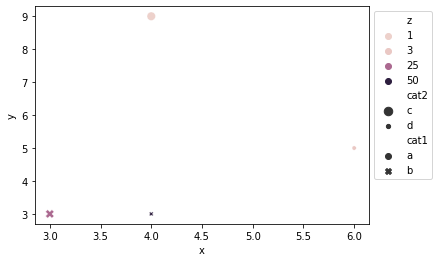

In [3]:
sns.scatterplot(x='x', y='y', hue='z', style='cat1', size='cat2', data=tmp)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

<hr>

### 1. [0.25 pt] Data Reading and Preprocessing

This is the same dataset that we used in assignment 3. So below you should do the following steps again:
* Read the seeds.csv into a dataframe.
* Create another dataframe that contains the scaled numerical variables.
* Create another dataframe that contains the scaled numerical variables and the seed class labels. Call this **df_stand**.

You should scale the variables the same way that you did in assignment 3 (ie. mean subtract and divide by the standard deviation).

In [25]:
df = pd.read_csv('seeds.csv')

In [26]:
df.head(2)

area  perimeter  compactness  kernel_length  width  asymmetry_coefficient  \
0  15.26      14.84       0.8710          5.762  2.212                  2.221   
1  14.88      14.57       0.8811          5.554  2.222                  1.018   

   kernel_groove_length seed_class  
0                 5.220       kama  
1                 4.956       kama

In [29]:
scaled_array=StandardScaler().fit_transform(df.loc[:, ~df.columns.str.contains('seed_class')])
scaled_array[:2]

array([[ 0.17415213,  0.38139295,  0.02247825,  0.33529961, -1.10305944,
        -0.78967363, -0.36112728],
       [ 0.04575837,  0.2161149 ,  0.43705533, -0.13052167, -1.07216265,
        -1.54950444, -0.90083226]])

In [28]:
df_stand = pd.DataFrame(scaled_array, columns= df.columns[:-1])
df_stand['seed_class'] = df.seed_class
df_stand.head(3)

area  perimeter  compactness  kernel_length     width  \
0  0.174152   0.381393     0.022478       0.335300 -1.103059   
1  0.045758   0.216115     0.437055      -0.130522 -1.072163   
2 -0.153590  -0.077713     1.418084      -0.719517 -1.056714   

   asymmetry_coefficient  kernel_groove_length seed_class  
0              -0.789674             -0.361127       kama  
1              -1.549504             -0.900832       kama  
2              -0.487762             -1.168640       kama

**Run this code below after you have created 'df_stand', to create a new column that has concatenated the class and the id of the seed.** 

We will use this later.

In [32]:
df_stand['seed_class_and_id']=df_stand['seed_class']+'-'+df_stand.index.astype(str)
df_stand.head()

area  perimeter  compactness  kernel_length     width  \
0  0.174152   0.381393     0.022478       0.335300 -1.103059   
1  0.045758   0.216115     0.437055      -0.130522 -1.072163   
2 -0.153590  -0.077713     1.418084      -0.719517 -1.056714   
3 -0.643513  -0.781675     1.028136      -0.869565 -0.896051   
4  0.471485   0.473214     1.311361       0.102389 -0.021672   

   asymmetry_coefficient  kernel_groove_length seed_class seed_class_and_id  
0              -0.789674             -0.361127       kama            kama-0  
1              -1.549504             -0.900832       kama            kama-1  
2              -0.487762             -1.168640       kama            kama-2  
3              -0.765672             -1.209527       kama            kama-3  
4              -1.399812             -0.453122       kama            kama-4

### 2. Basic Descriptive Analytics

#### 2.1. [0.5 pt] Pairwise scatterplots
For every pair of **scaled** numerical attributes, plot a scatterplot, color-coding the points by the seed class labels.

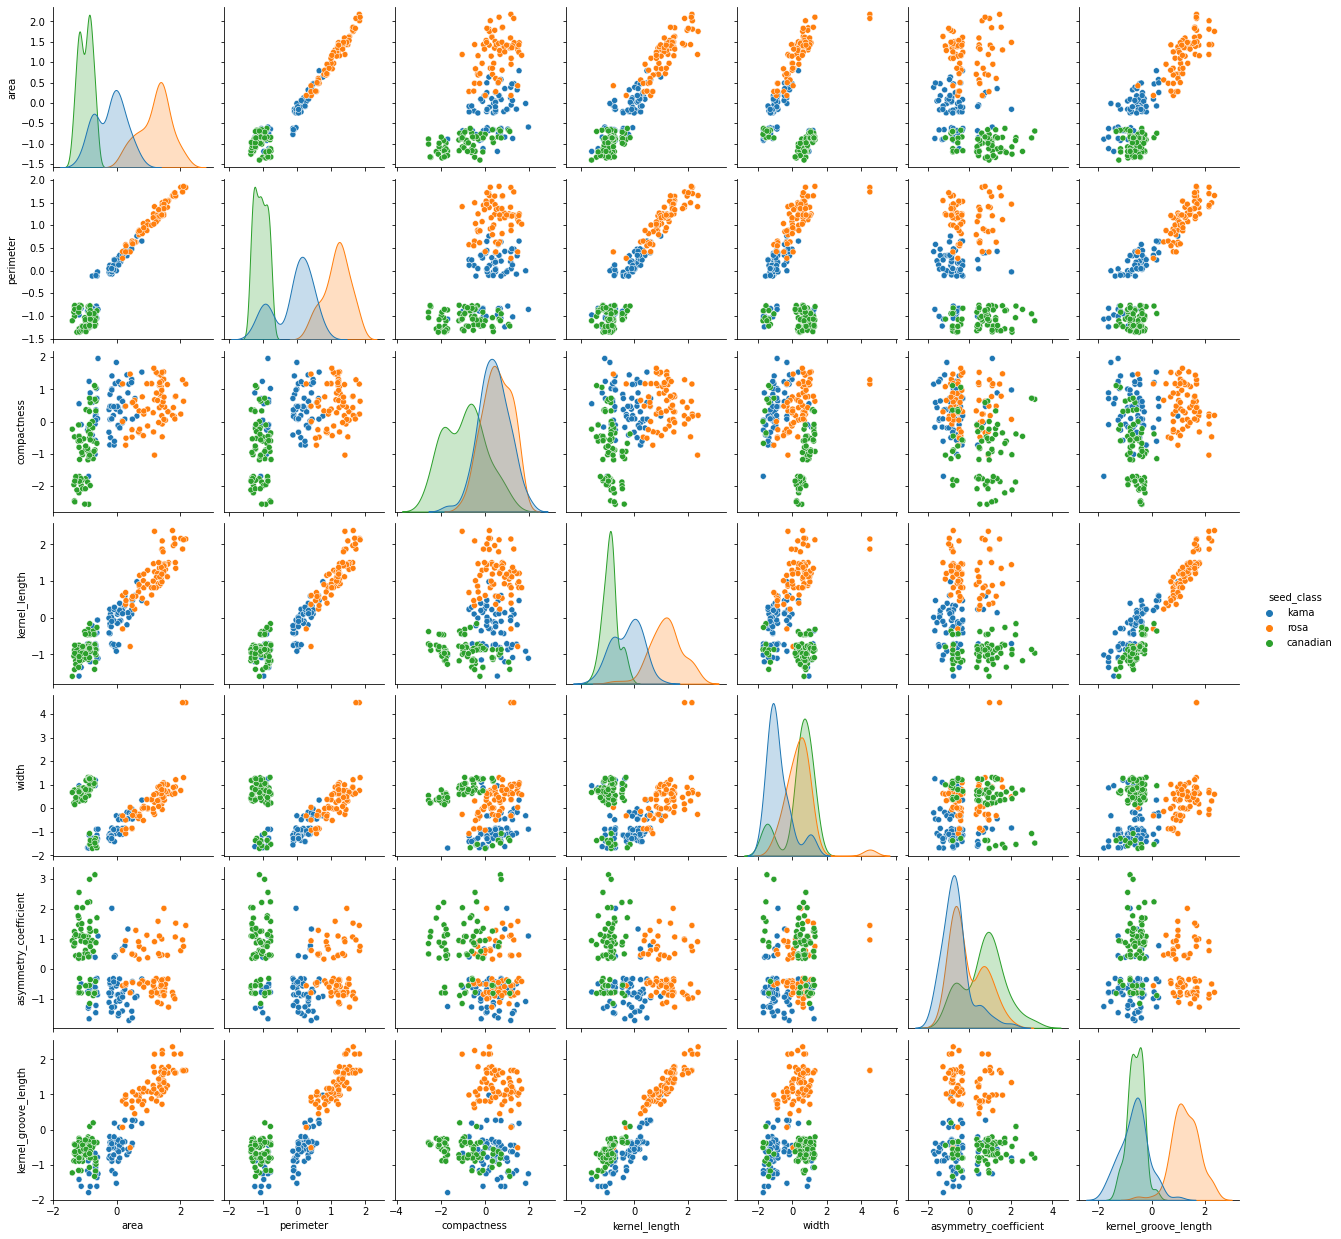

In [33]:
sns.pairplot(df_stand, hue='seed_class')
plt.show()

#### 2.2. [0.25 pt] Outliers

Is there any evidence of outliers in this dataset?

> Yes, there are two objects belonging to kama that have very large width compared to other kama objects, or all objects in general.

### 3. Pre-Cluster Analysis

#### 3.1. [0.25 pt] t-SNE Plot with Seed Class Labels

Using the perplexity value and the random state that you used in Assignment 3, plot the t-SNE scatterplot for this **scaled** dataset, color-coding the points by the seed class labels.

In [46]:
df_stand.iloc[:, :-2][:5]

area  perimeter  compactness  kernel_length     width  \
0  0.174152   0.381393     0.022478       0.335300 -1.103059   
1  0.045758   0.216115     0.437055      -0.130522 -1.072163   
2 -0.153590  -0.077713     1.418084      -0.719517 -1.056714   
3 -0.643513  -0.781675     1.028136      -0.869565 -0.896051   
4  0.471485   0.473214     1.311361       0.102389 -0.021672   

   asymmetry_coefficient  kernel_groove_length  
0              -0.789674             -0.361127  
1              -1.549504             -0.900832  
2              -0.487762             -1.168640  
3              -0.765672             -1.209527  
4              -1.399812             -0.453122

In [44]:
data_tsne[:2]

array([[ -7.254705 , -21.08751  ],
       [-10.1194515, -13.920977 ]], dtype=float32)

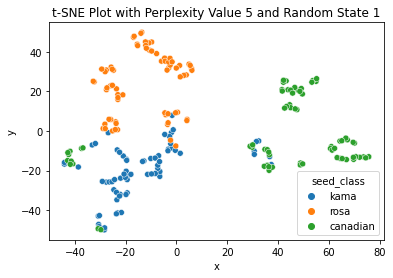

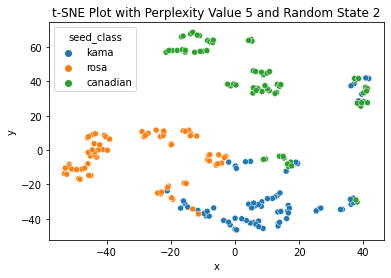

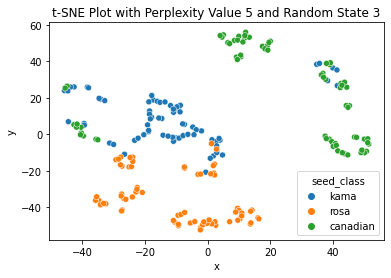

--------------------------------------------


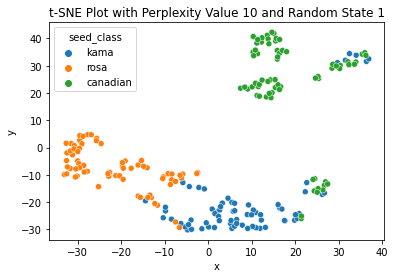

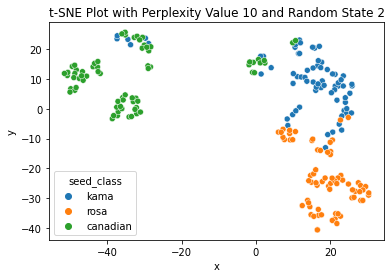

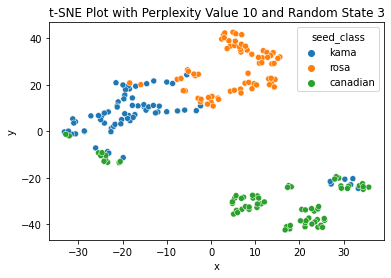

--------------------------------------------


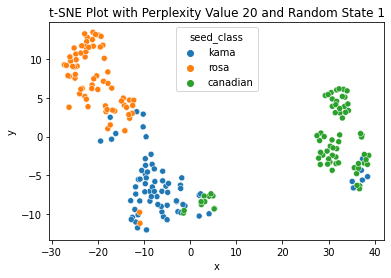

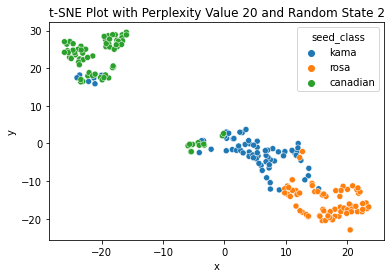

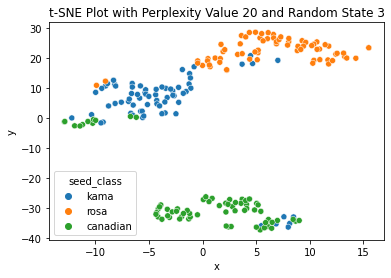

--------------------------------------------


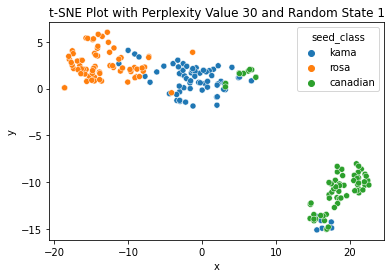

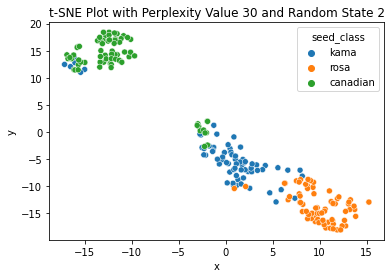

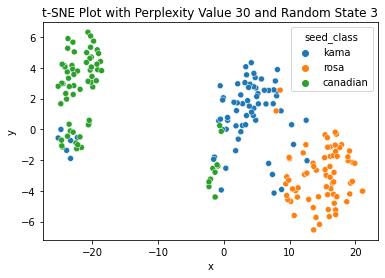

--------------------------------------------


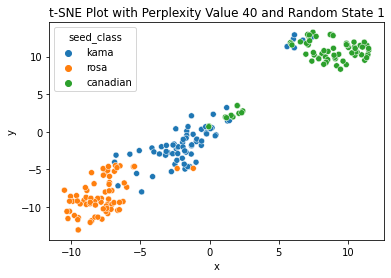

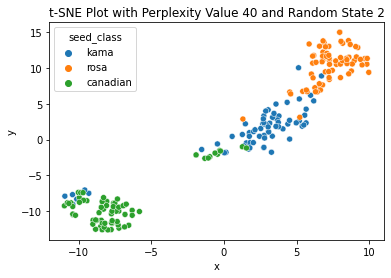

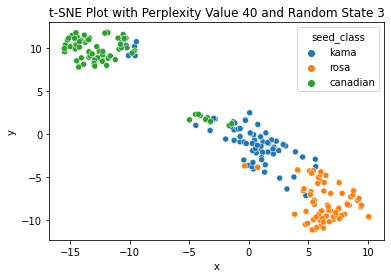

--------------------------------------------


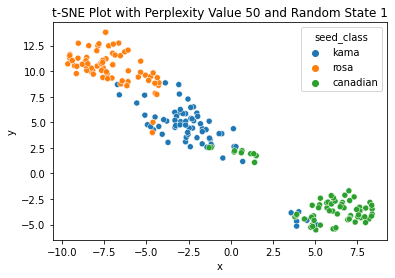

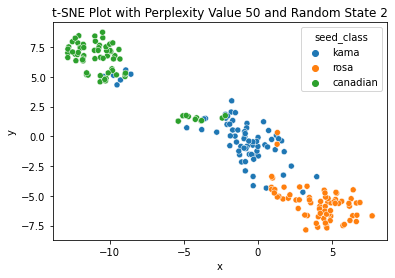

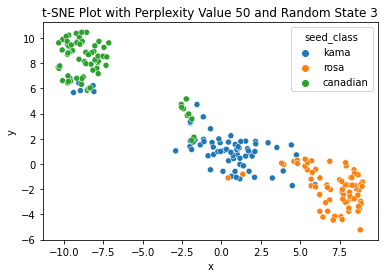

--------------------------------------------


In [45]:
for perp in [5,10, 20, 30, 40, 50]:
    for rs in [1,2,3]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
        data_tsne = tsne.fit_transform(df_stand.iloc[:, :-2])
        df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])
        df_combo = pd.concat([df_stand.seed_class, df_tsne], axis=1)
        sns.scatterplot(x='x',y='y', hue='seed_class', data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
        plt.show()
    print('--------------------------------------------')

#### 3.2. [1 pt] Nested Sub-Clusters

Looking at your t-SNE plot, is there evidence to suggest that there may be sub-**clusters** in the scaled dataset? Explain. 

*(This answer is subjective. As long as your reasoning is accurate and explained, then you will get full credit).*

> We can see from t-SNE with perplexity 30 and state 2 or state 3, more than 3 clusters emerge. This tells us that there may be subclusters present.

#### 3.3.  [1 pt] Sub-Classes of Seeds

Looking at your t-SNE plot, is there evidence to suggest that there may be different sub-**classes** of one or more seed class? Explain.

*(This answer is subjective. As long as your reasoning is accurate and explained, then you will get full credit).*

> We can see from almost all t-SNE plots that there are few canadian seed class objects that overlap with kama seed class at the same time there are few kama seed class objects that get mixed with canadian seed class objects

> This tells us that there may be subclasses present.

### 4. Clustering Algorithm Selection - Given Knowledge about the Dataset

#### 4.1.  [1 pt] k-Means
Give at least one reason why k-means may not be the "ideal" algorithm to cluster this dataset.

1. The clusters are not spherical
2. Boundaries are not well seperated and there are overlapped objects
3. Sparsity is not constant among all clusters.

#### 4.2.  [1 pt] Hierarchical Agglomerative Clustering with Single Linkage

Give at least one reason why hierarchical agglomerative clustering with single linkage may not be the "ideal" algorithm to cluster this dataset for the purpose of identifying clusters (and perhaps subclusters) in the dataset.

1. There are overlapping clusters. It doesn't work well with overlapping clusters.
2. There is noise present in the dataset.

#### 4.3.  [1 pt] Hierarchical Agglomerative Clustering with Ward's Linkage
Give at least one reason why hierarchical agglomerative clustering with Ward's linkage may not be the "ideal" algorithm to cluster this dataset for the purpose of identifying clusters (and perhaps subclusters) in the dataset.

1. The clusters are not spherical
2. Boundaries are not well seperated and there are overlapped objects
3. Sparsity is not constant among all clusters.

### 5. Clustering Algorithm Selection - Using Average Silhouette Score

#### 5.1.  [2 pt] Average Silhouette Score Plots

Create 5 average silhouette score plots with this **scaled** dataset, one for each of the following clustering algorithms:
* k-means
* Hierarchical agglomerative clustering with single linkage
* Hierarchical agglomerative clustering with average linkage
* Hierarchical agglomerative clustering with complete linkage
* Hierarchical agglomerative clustering with Ward's linkage

Each of your average silhouette score plots should plot the average silhouette score for clusterings with k=2, k=3, ..., k=14 clusters, respectively.

higest avg. silhouette score with knn 0.4234290697311969 with no. of clusters: 3


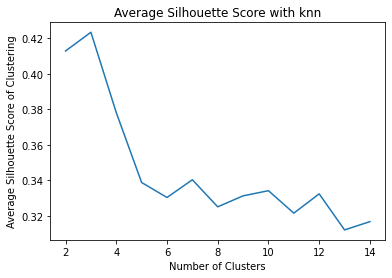

higest avg. silhouette score with single linkage 0.45642651762574954 with no. of clusters: 2


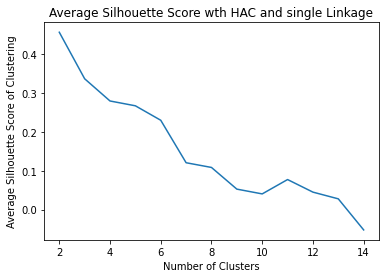

higest avg. silhouette score with complete linkage 0.3800157904924517 with no. of clusters: 2


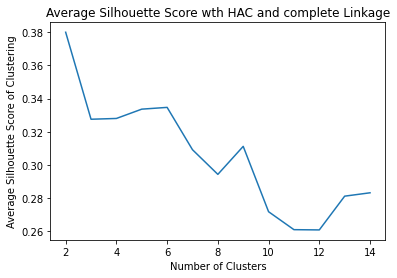

higest avg. silhouette score with ward linkage 0.4197384897382831 with no. of clusters: 3


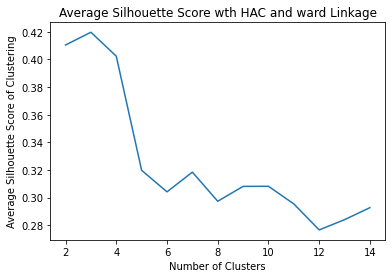

higest avg. silhouette score with average linkage 0.45642651762574954 with no. of clusters: 2


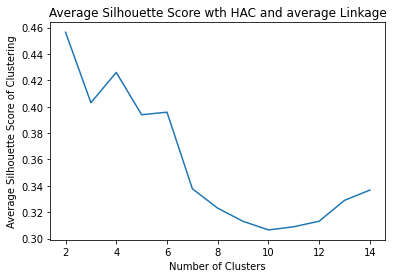

In [74]:
avg_ss={}
for k in range(2,15):
        kmeans=KMeans(n_clusters=k).fit(df_stand.iloc[:,:-2])
        Y_pred = kmeans.labels_
        avg_ss.update({silhouette_score(df_stand.iloc[:,:-2], Y_pred):k})
        
print('higest avg. silhouette score with knn', max(avg_ss.keys()), 'with no. of clusters:', avg_ss[max(avg_ss.keys())])
plt.plot(range(2,15), avg_ss.keys())
plt.title(f'Average Silhouette Score with knn')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score of Clustering')
plt.show()

for link in ['single', 'complete', 'ward', 'average']:
    avg_ss={}
    for k in range(2,15):
        #First, designate the HAC linkage function, and the number of clusters you want to extract from the resulting dendrogram
        hac = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage=link)
        Y_pred = hac.fit_predict(df_stand.iloc[:,:-2])
        avg_ss.update({silhouette_score(df_stand.iloc[:,:-2], Y_pred):k})
        
    print(f'higest avg. silhouette score with {link} linkage', max(avg_ss.keys()), 'with no. of clusters:', avg_ss[max(avg_ss.keys())])
    plt.plot(range(2,15), avg_ss.keys())
    plt.title('Average Silhouette Score wth HAC and %s Linkage'%link)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Silhouette Score of Clustering')
    plt.show()

#### 5.2. Interpreting Average Silhouette Score Plots

Use your five plots above to answer the following questions below.

* **5.2.1.**  [1 pt] Which clustering algorithm(s) and cluster number(s) (k) yields the clustering with the best cohesion and separation in this dataset? Explain.

* **5.2.2.**  [1 pt] What do these plot suggest is the "best" number of clusters to ask each of the 5 clustering algorithms for? Explain.

> Single linkage and ward linkage give highest silhouette score of 0.4564 with two clusters. Hence this would give us best cohesion and separation.

- knn: 3
- HAC single linkage: 2
- HAC complete linkage: 2
- HAC ward linkage: 3
- HAC average linkage: 2

### 6. Hierarchical Agglomerative Clustering with Single Linkage



#### 6.1. [0.5 pt] Dendrogram

Create a dendrogram using hierarchical agglomerative clustering with single linkage for the **scaled** dataset. 
* Label the points with the 'seed_class_and_id' column that we created in part 1. 
* Make sure you are able to read the seed_class_and_id labels in your dendrogram.

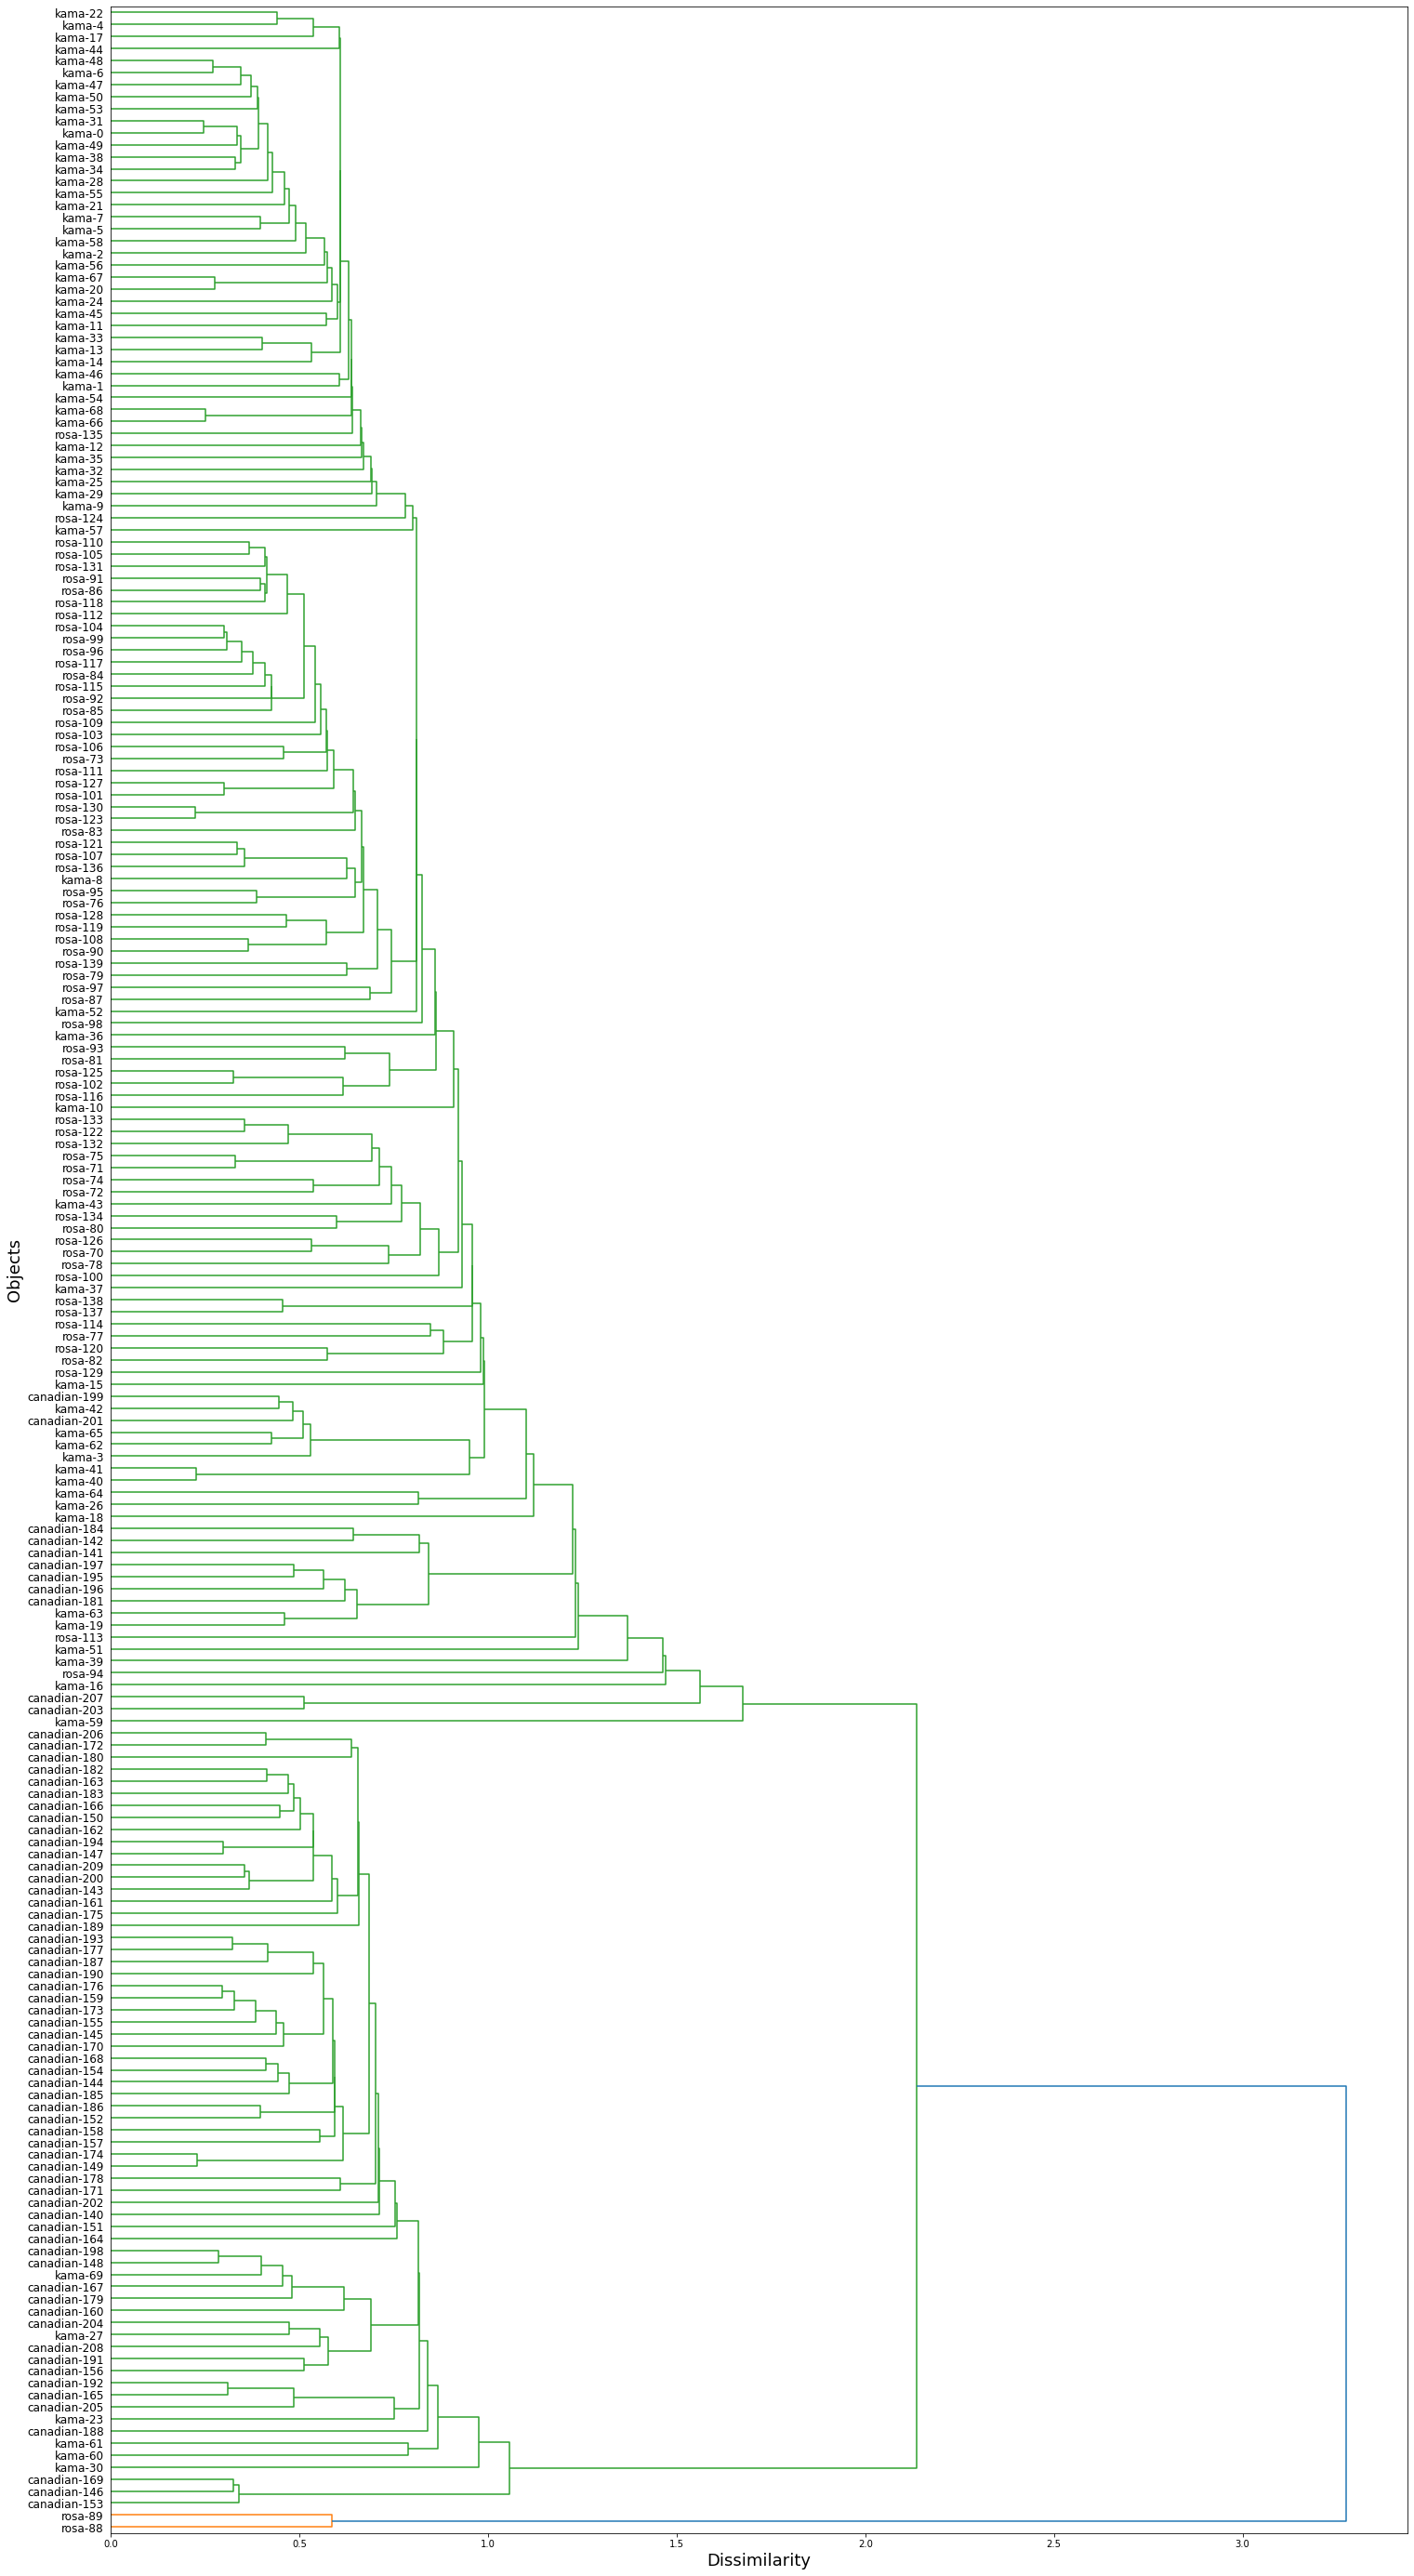

In [78]:
X = df_stand.iloc[:,:-2]
Z = linkage(X, method='single')

fig, ax = plt.subplots(figsize=(25, 50))
d = dendrogram(Z, orientation='right', labels=df_stand.seed_class_and_id.array, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Objects', fontsize=18)
plt.yticks(fontsize=12)
plt.show()

#### 6.2. [0.5 pt] t-SNE Individual Clustering Visualization

Then for each of the clusterings with k=2,k=3,...,k=14 clusters, color code the points in your selected t-SNE plot with the respective cluster labels. Also, define the **shape** of the points by the seed class.

In [94]:
# for link in ['single', 'complete', 'ward', 'average']:

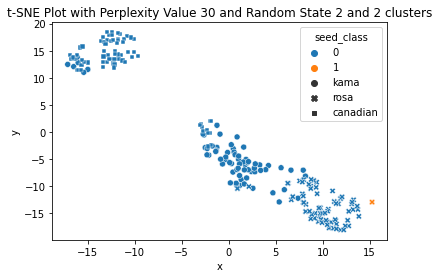

--------------------------------------------


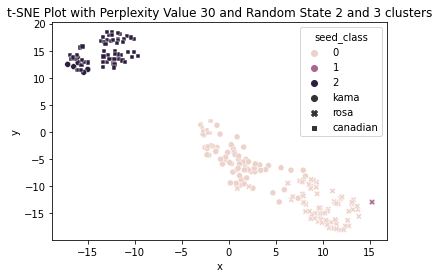

--------------------------------------------


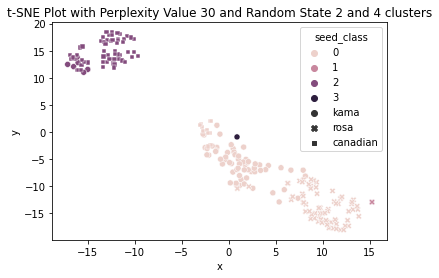

--------------------------------------------


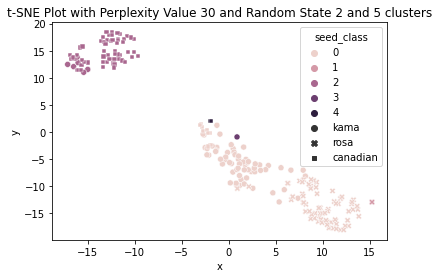

--------------------------------------------


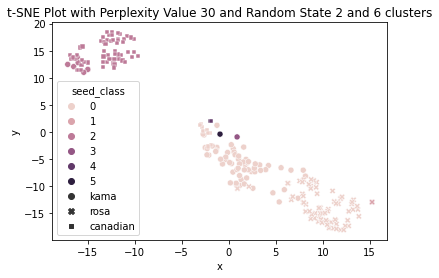

--------------------------------------------


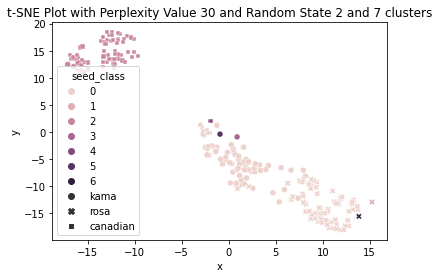

--------------------------------------------


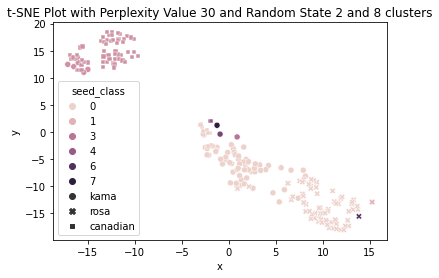

--------------------------------------------


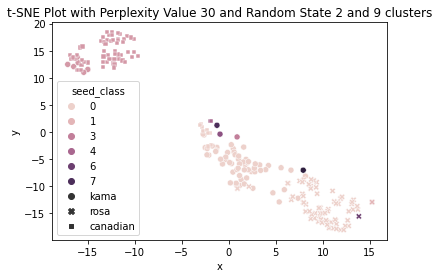

--------------------------------------------


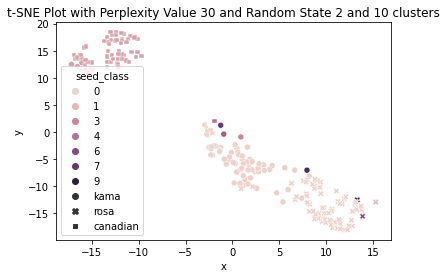

--------------------------------------------


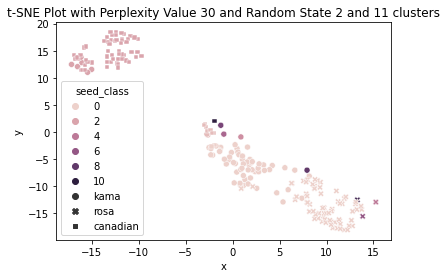

--------------------------------------------


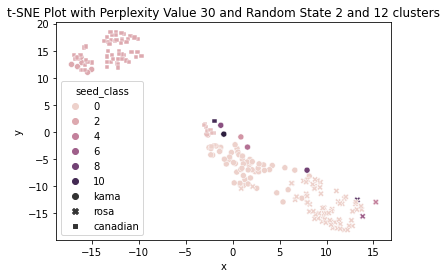

--------------------------------------------


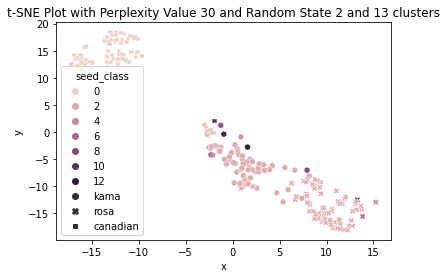

--------------------------------------------


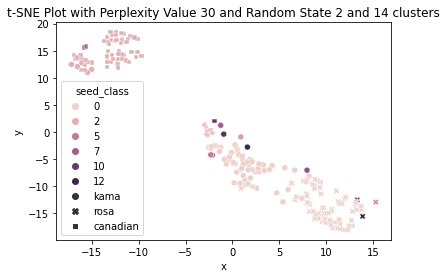

--------------------------------------------


In [93]:
data_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])
tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)

for k in range(2,15):
    #First, designate the HAC linkage function, and the number of clusters you want to extract from the resulting dendrogram
    hac = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='single')
    Y_pred = hac.fit_predict(X)
    perp = 30
    rs = 2

    df_combo = pd.concat([pd.DataFrame(Y_pred), df_tsne, df_stand.seed_class], axis=1)
    sns.scatterplot(x='x',y='y', hue=Y_pred, data=df_combo, style = df_stand.seed_class)
    plt.title('t-SNE Plot with Perplexity Value %s and Random State %s and %s clusters' %(perp, rs, k))
    plt.show()
    print('--------------------------------------------')

### 7. Hierarchical Agglomerative Clustering with Average Linkage



#### 7.1. [0.5 pt] Dendrogram

Create a dendrogram using hierarchical agglomerative clustering with average linkage for the **scaled** dataset. 
* Label the points with the 'seed_class_and_id' column that we created in part 1. 
* Make sure you are able to read the seed_class_and_id labels in your dendrogram.

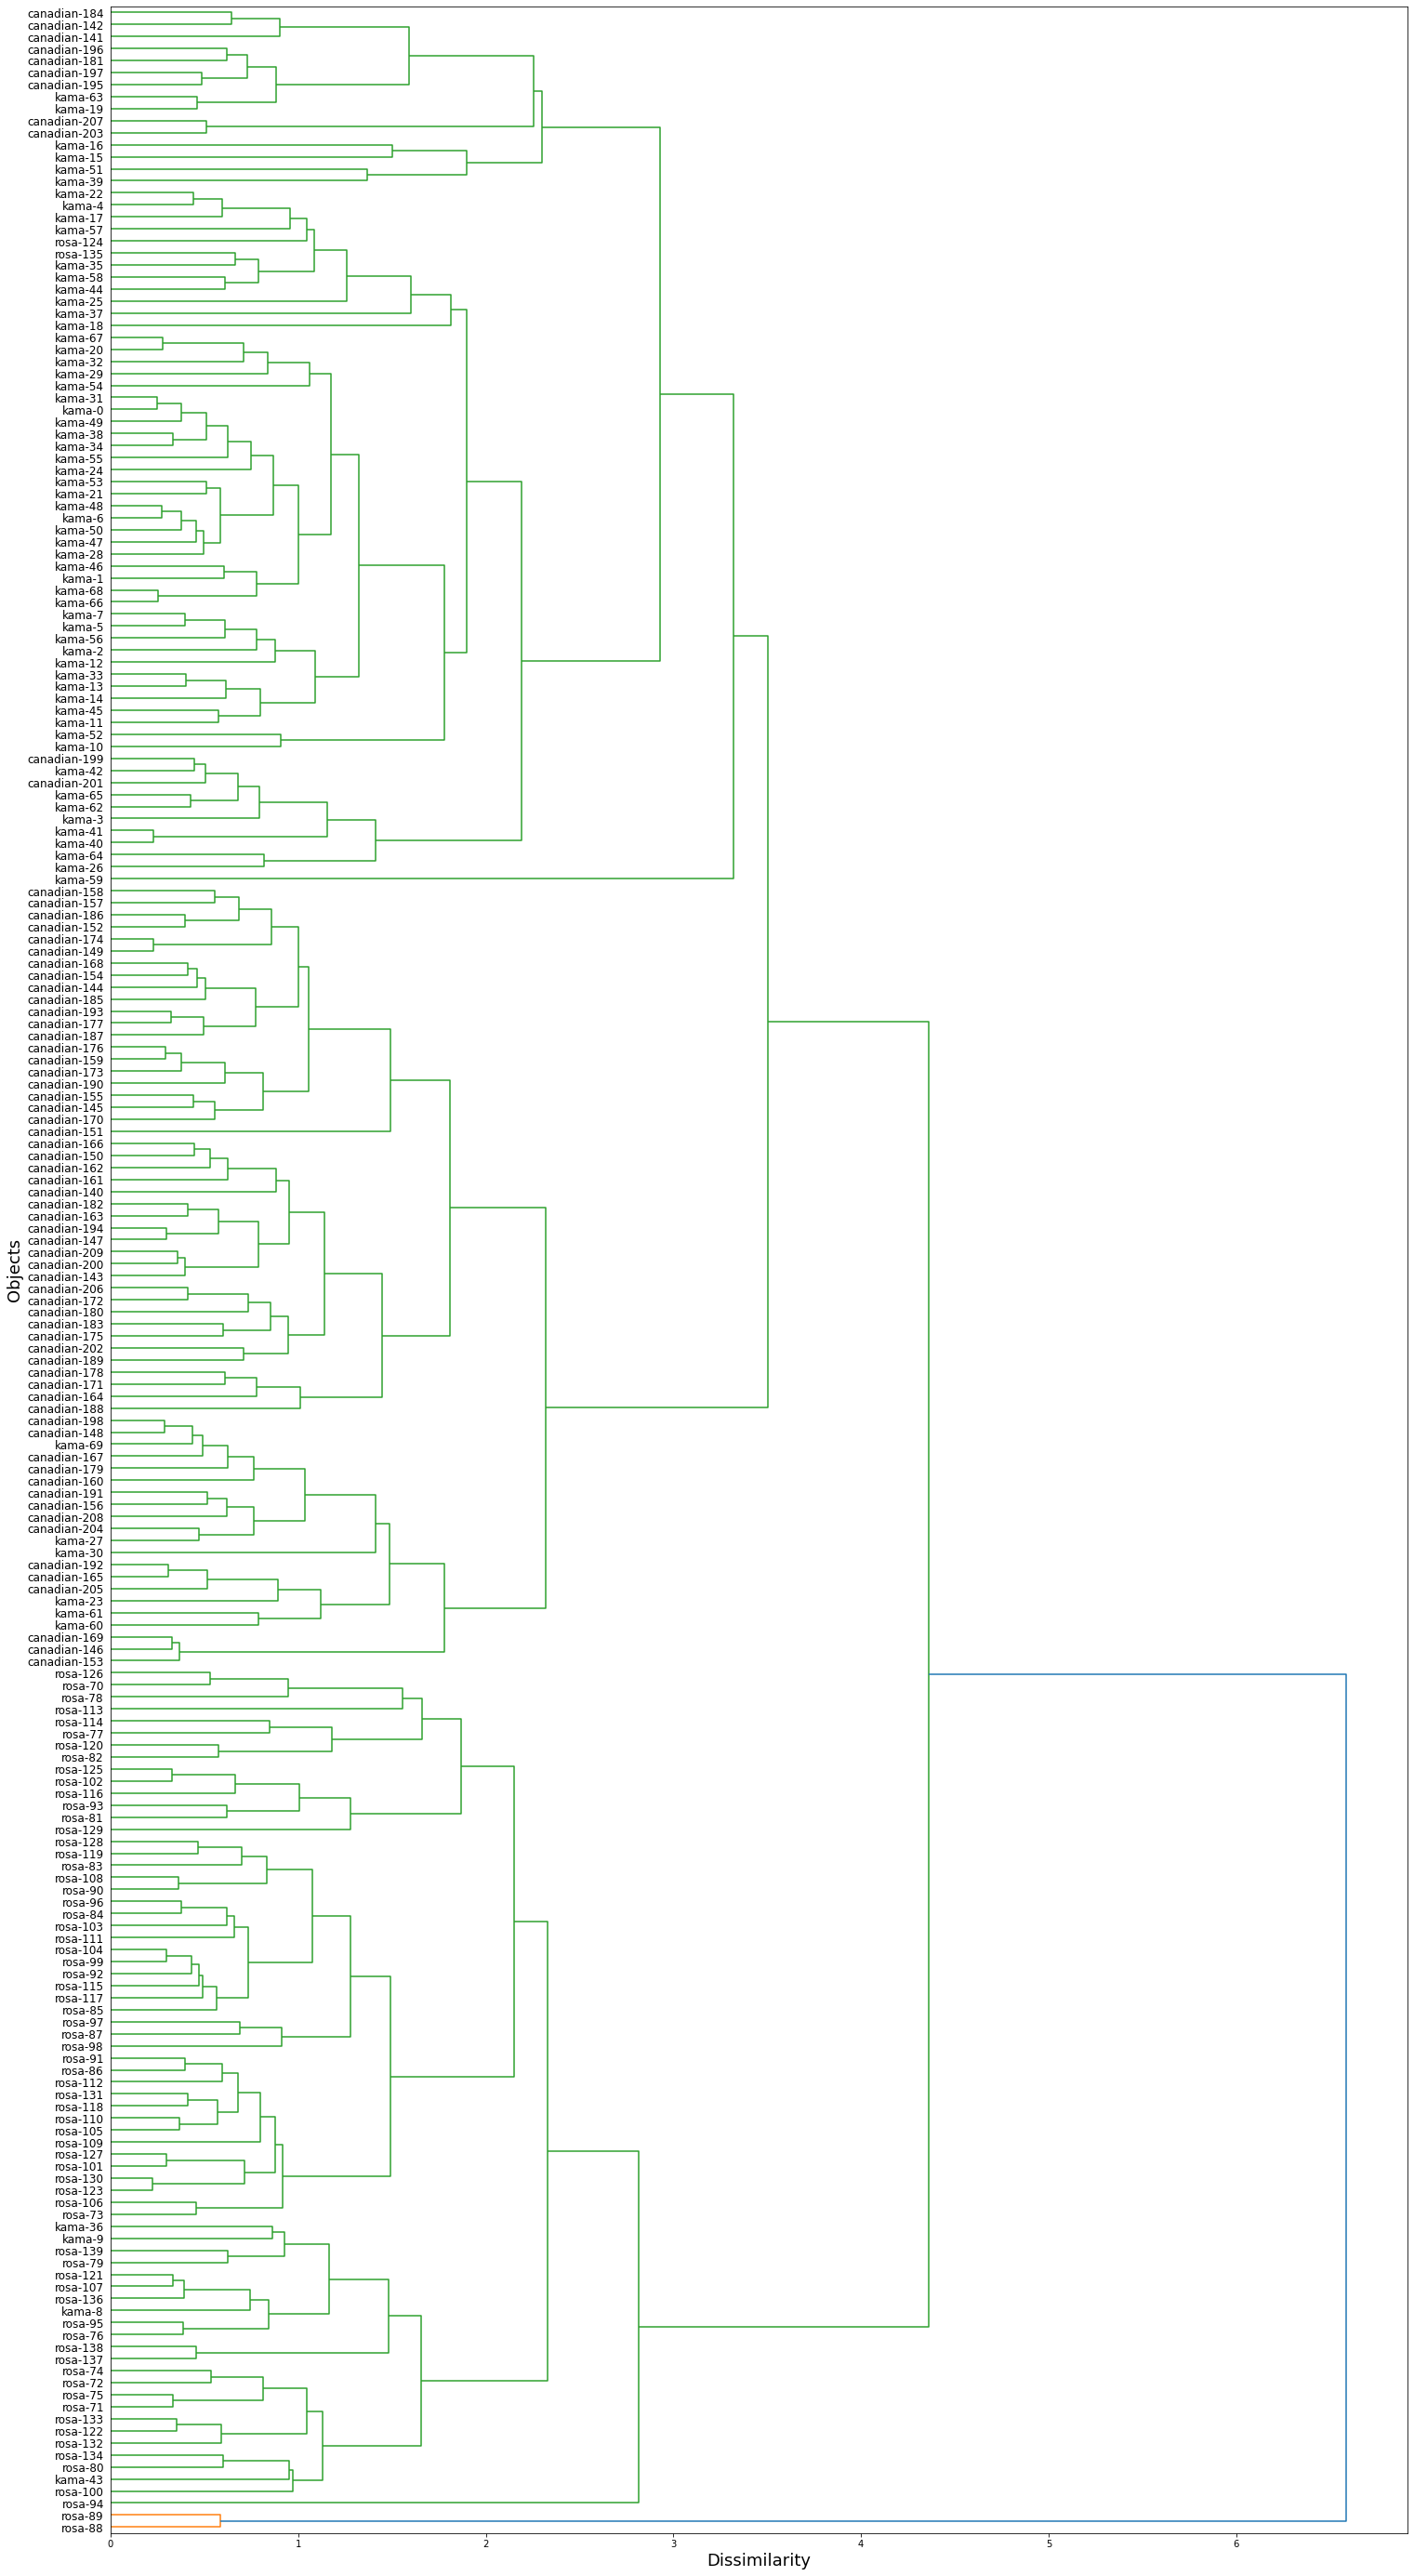

In [95]:
X = df_stand.iloc[:,:-2]
Z = linkage(X, method='average')

fig, ax = plt.subplots(figsize=(25, 50))
d = dendrogram(Z, orientation='right', labels=df_stand.seed_class_and_id.array, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Objects', fontsize=18)
plt.yticks(fontsize=12)
plt.show()

#### 7.2. [0.5 pt] t-SNE Individual Clustering Visualization

Then for each of the clusterings with k=2,k=3,...,k=14 clusters, color code the points in your selected t-SNE plot with the respective cluster labels. Also, define the **shape** of the points by the seed class.

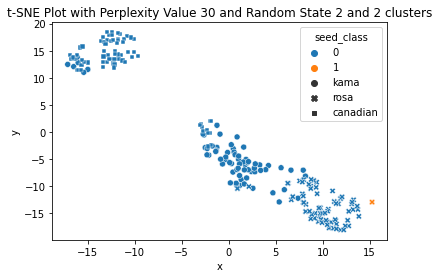

--------------------------------------------


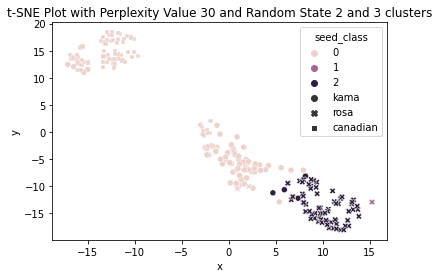

--------------------------------------------


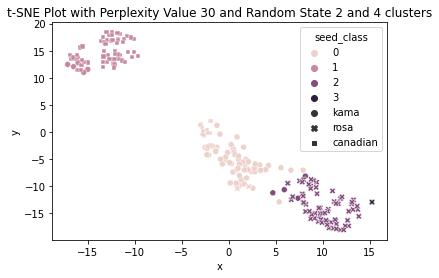

--------------------------------------------


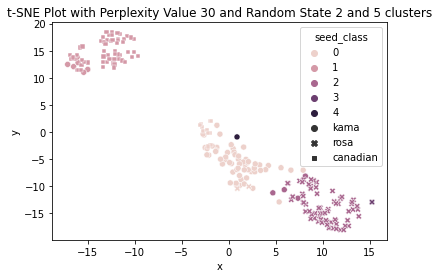

--------------------------------------------


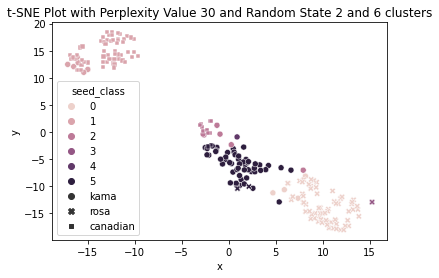

--------------------------------------------


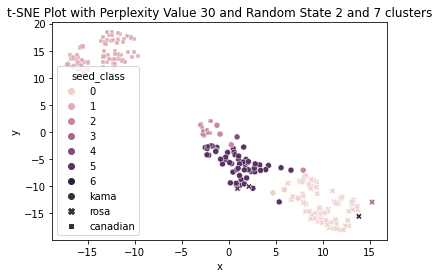

--------------------------------------------


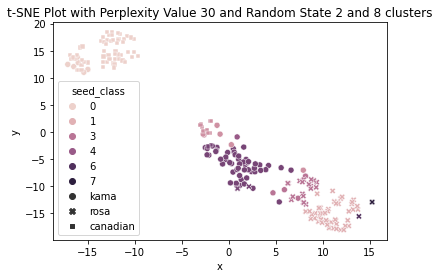

--------------------------------------------


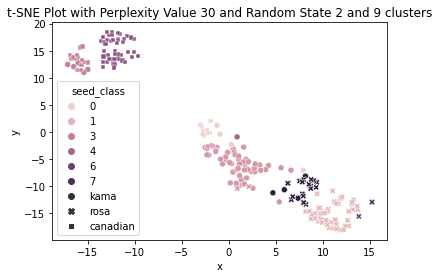

--------------------------------------------


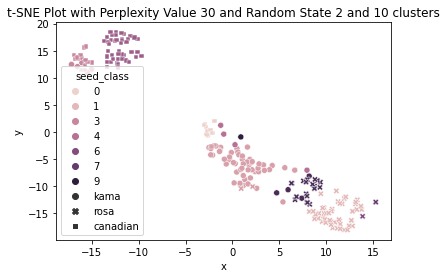

--------------------------------------------


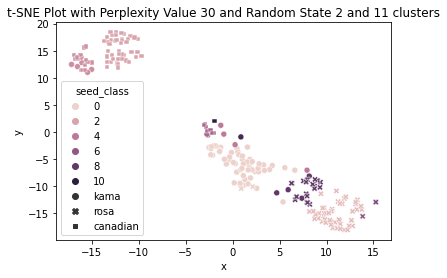

--------------------------------------------


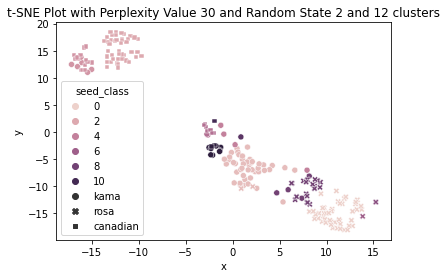

--------------------------------------------


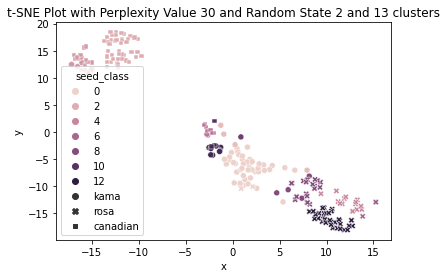

--------------------------------------------


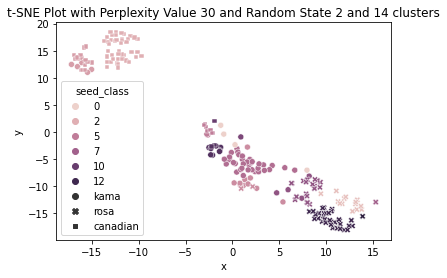

--------------------------------------------


In [96]:
data_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])
tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)

for k in range(2,15):
    #First, designate the HAC linkage function, and the number of clusters you want to extract from the resulting dendrogram
    hac = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='average')
    Y_pred = hac.fit_predict(X)
    perp = 30
    rs = 2

    df_combo = pd.concat([pd.DataFrame(Y_pred), df_tsne, df_stand.seed_class], axis=1)
    sns.scatterplot(x='x',y='y', hue=Y_pred, data=df_combo, style = df_stand.seed_class)
    plt.title('t-SNE Plot with Perplexity Value %s and Random State %s and %s clusters' %(perp, rs, k))
    plt.show()
    print('--------------------------------------------')

### 8. Hierarchical Agglomerative Clustering with Complete Linkage



#### 8.1. [0.5 pt] Dendrogram

Create a dendrogram using hierarchical agglomerative clustering with complete linkage for the **scaled** dataset. 
* Label the points with the 'seed_class_and_id' column that we created in part 1. 
* Make sure you are able to read the seed_class_and_id labels in your dendrogram.

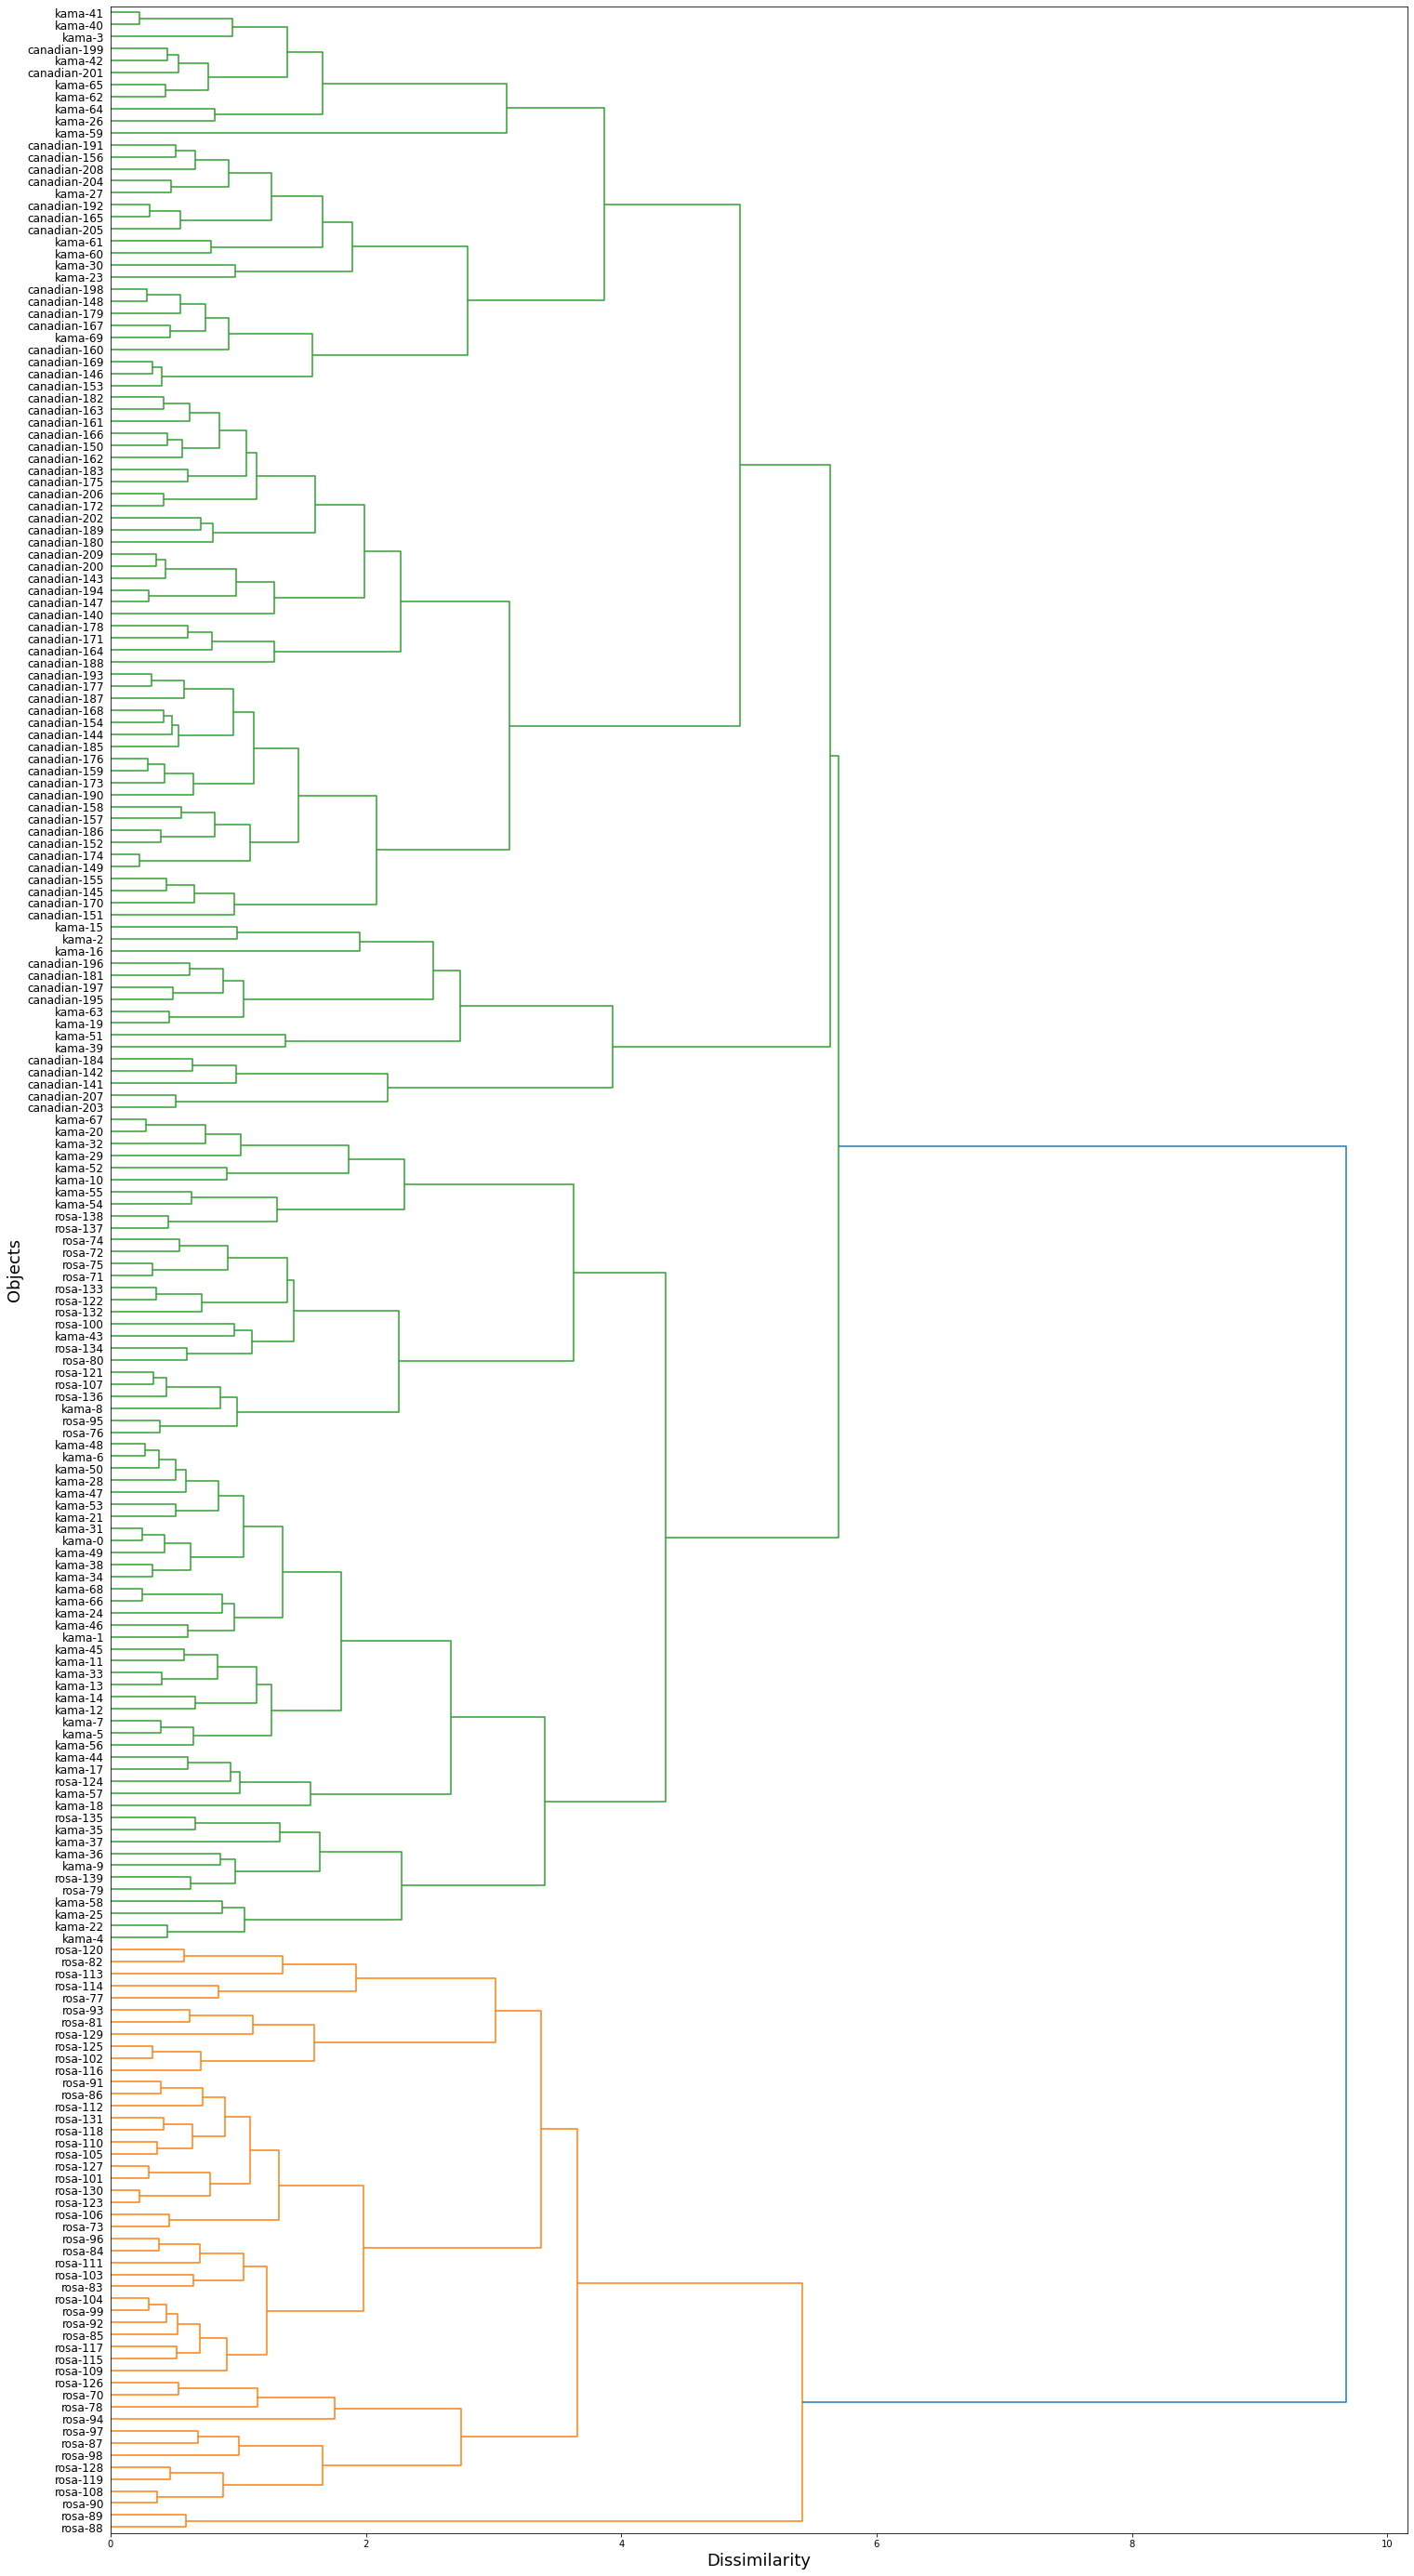

In [97]:
X = df_stand.iloc[:,:-2]
Z = linkage(X, method='complete')

fig, ax = plt.subplots(figsize=(25, 50))
d = dendrogram(Z, orientation='right', labels=df_stand.seed_class_and_id.array, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Objects', fontsize=18)
plt.yticks(fontsize=12)
plt.show()

#### 8.2. [0.5 pt] t-SNE Individual Clustering Visualization

Then for each of the clusterings with k=2,k=3,...,k=14 clusters, color code the points in your selected t-SNE plot with the respective cluster labels. Also, define the **shape** of the points by the seed class.

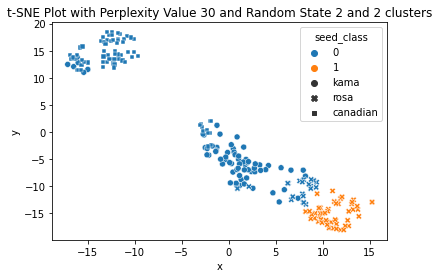

--------------------------------------------


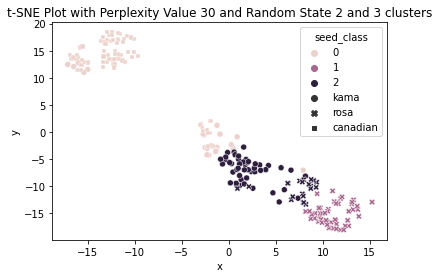

--------------------------------------------


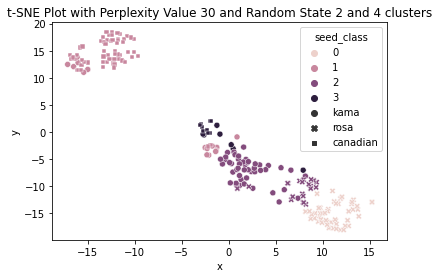

--------------------------------------------


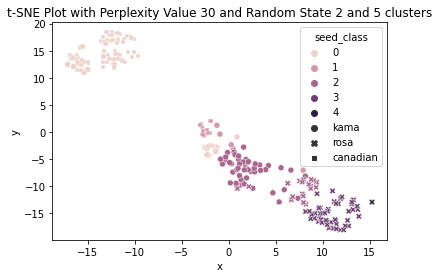

--------------------------------------------


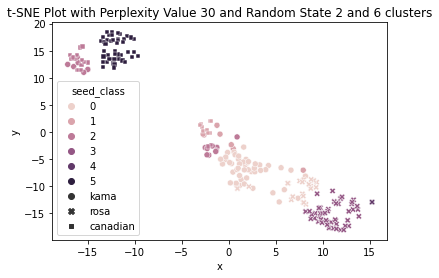

--------------------------------------------


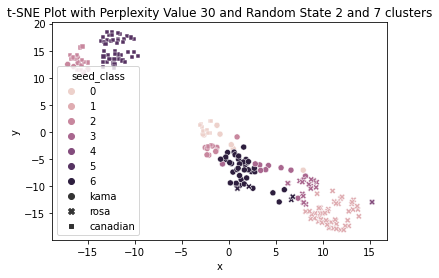

--------------------------------------------


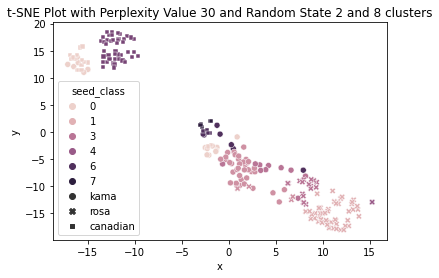

--------------------------------------------


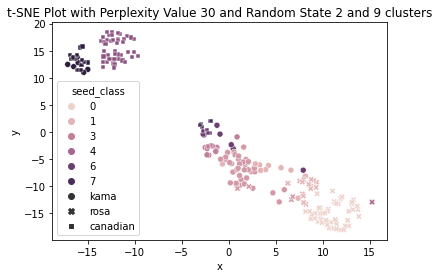

--------------------------------------------


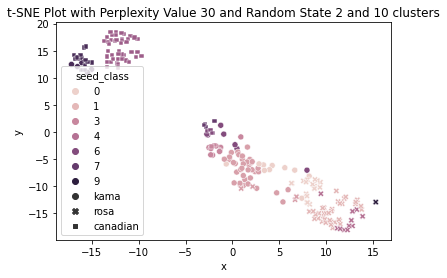

--------------------------------------------


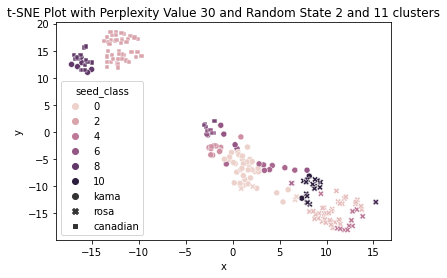

--------------------------------------------


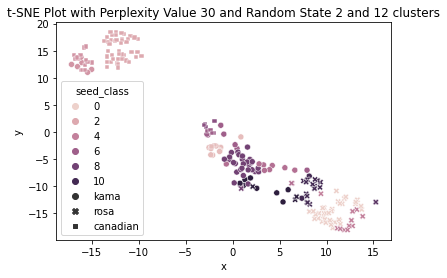

--------------------------------------------


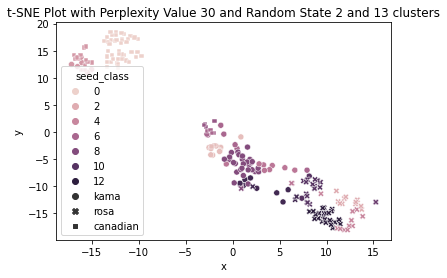

--------------------------------------------


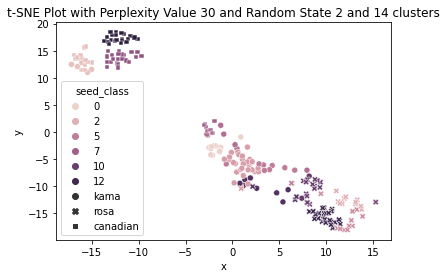

--------------------------------------------


In [98]:
data_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])
tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)

for k in range(2,15):
    #First, designate the HAC linkage function, and the number of clusters you want to extract from the resulting dendrogram
    hac = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='complete')
    Y_pred = hac.fit_predict(X)
    perp = 30
    rs = 2

    df_combo = pd.concat([pd.DataFrame(Y_pred), df_tsne, df_stand.seed_class], axis=1)
    sns.scatterplot(x='x',y='y', hue=Y_pred, data=df_combo, style = df_stand.seed_class)
    plt.title('t-SNE Plot with Perplexity Value %s and Random State %s and %s clusters' %(perp, rs, k))
    plt.show()
    print('--------------------------------------------')

### 9. Hierarchical Agglomerative Clustering with Ward's Linkage



#### 9.1. [0.5 pt] Dendrogram

Create a dendrogram using hierarchical agglomerative clustering with Ward's linkage for the **scaled** dataset. 
* Label the points with the 'seed_class_and_id' column that we created in part 1. 
* Make sure you are able to read the seed_class_and_id labels in your dendrogram.

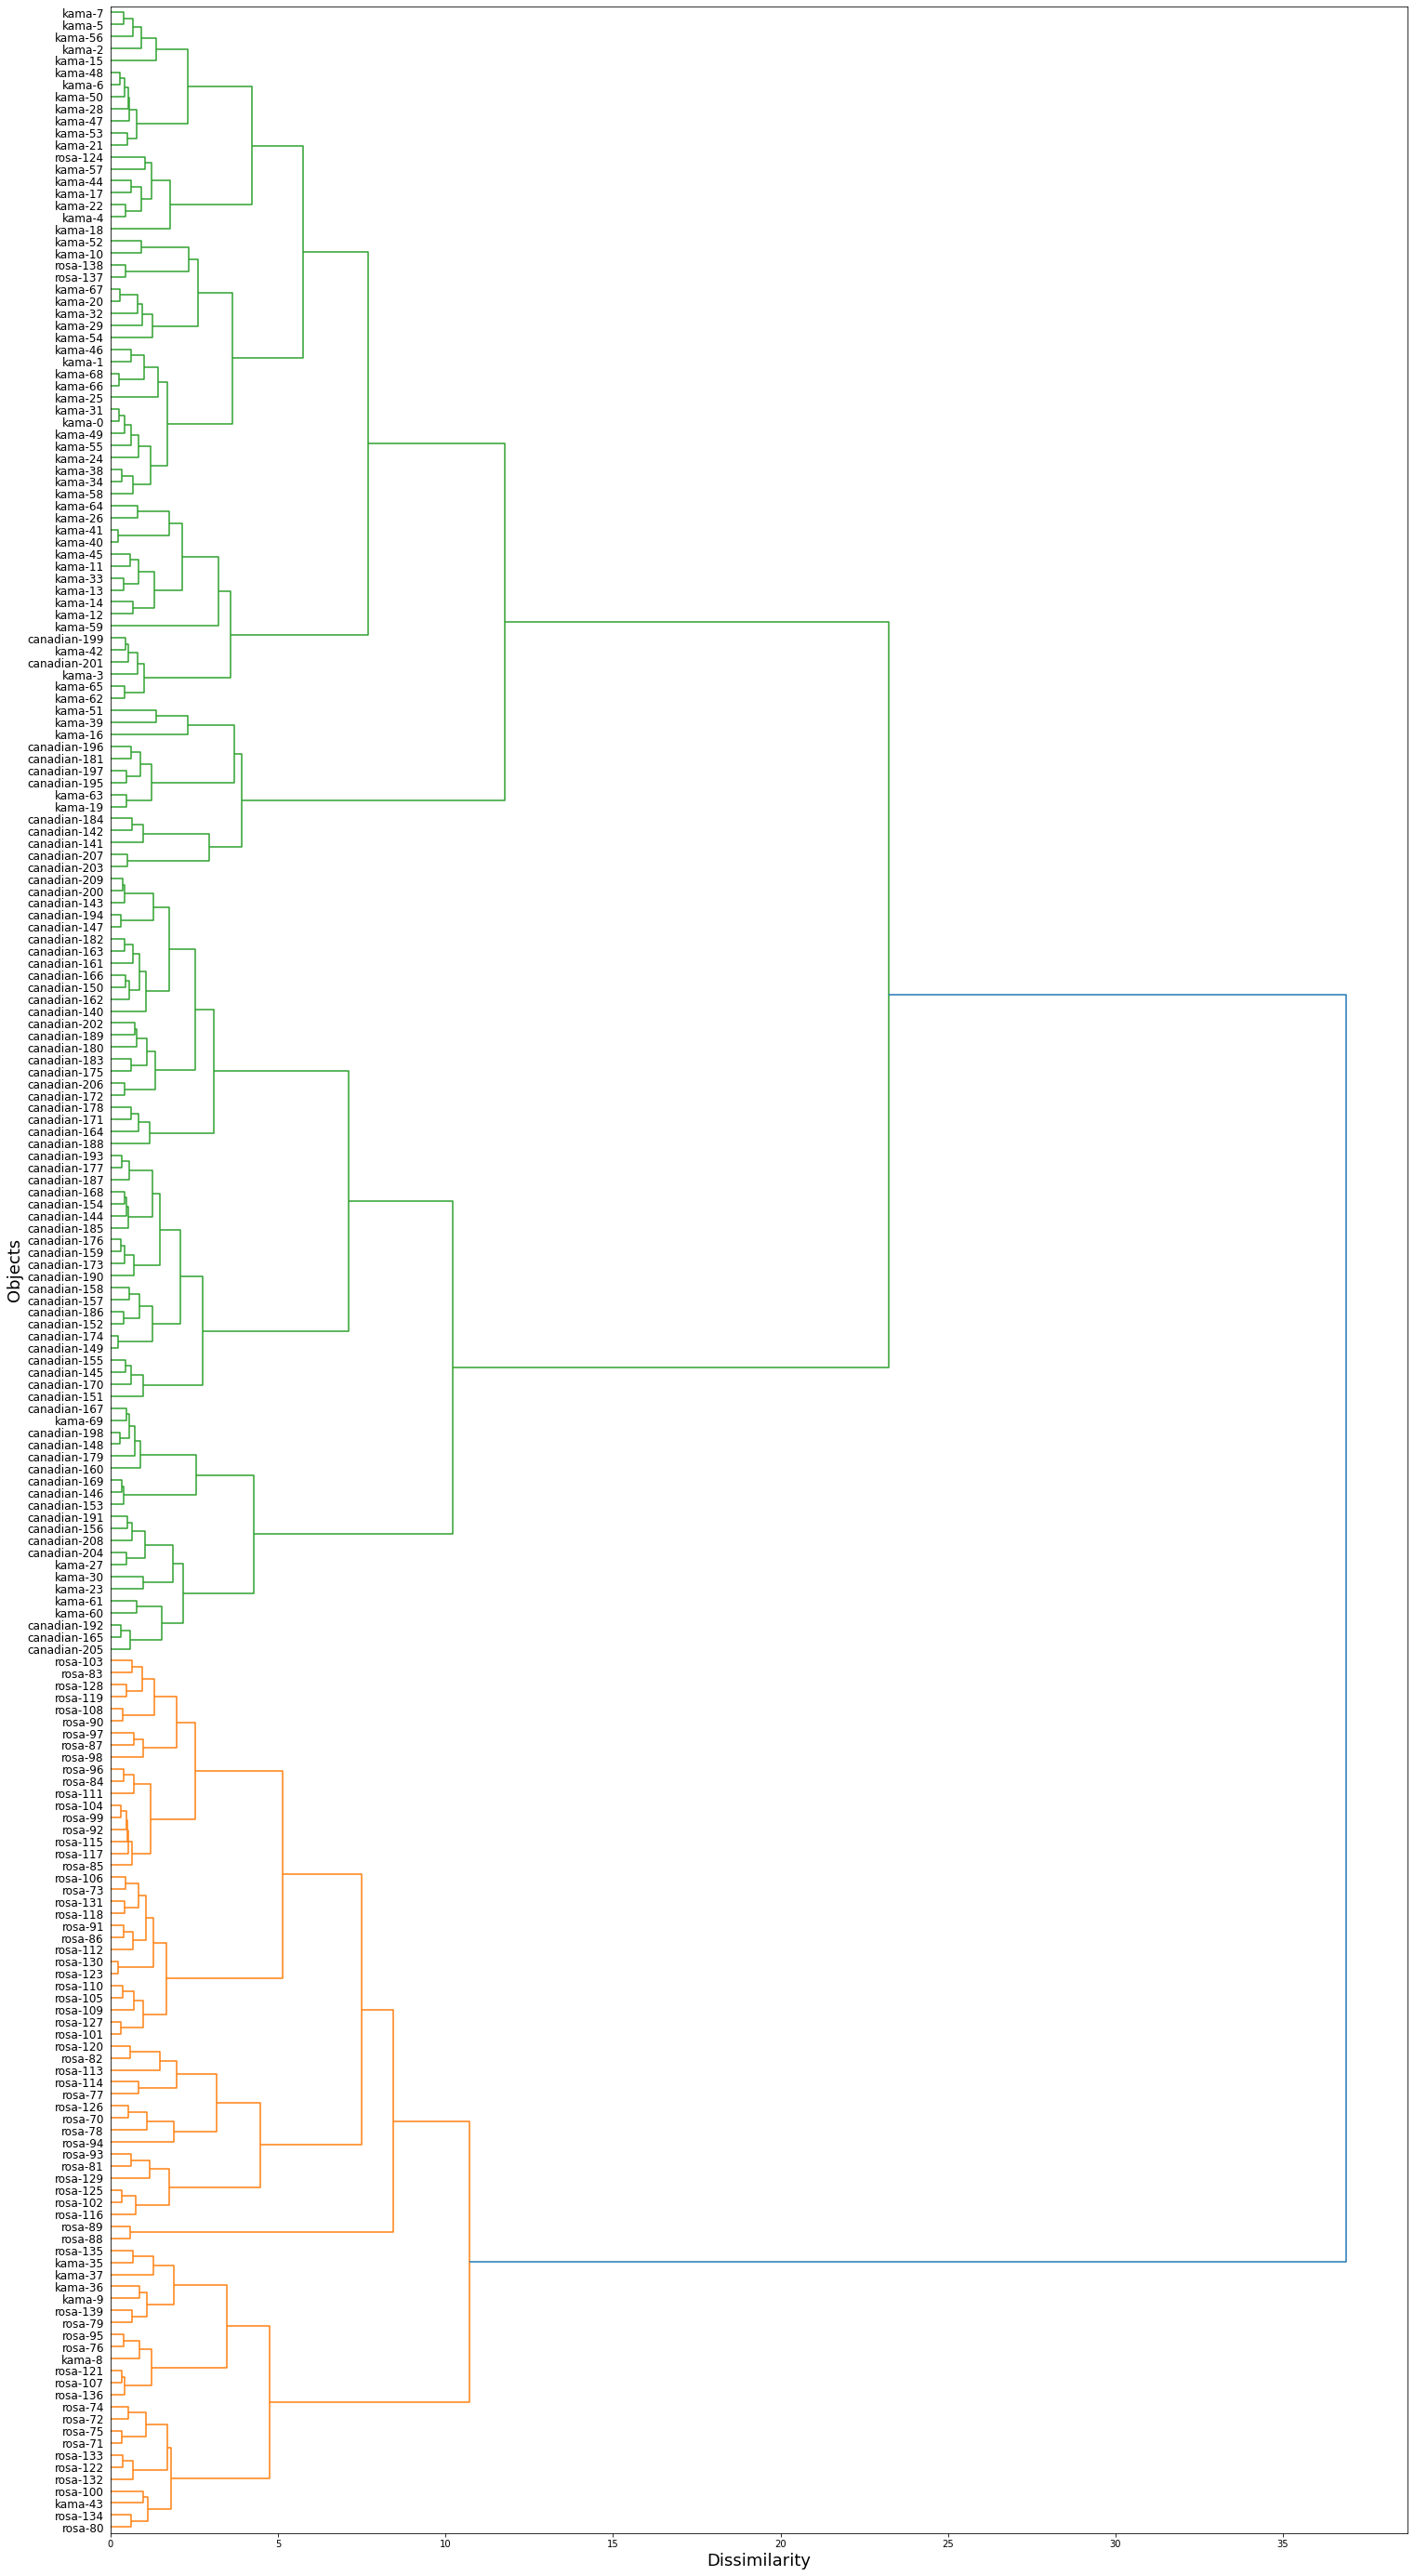

In [99]:
X = df_stand.iloc[:,:-2]
Z = linkage(X, method='ward')

fig, ax = plt.subplots(figsize=(25, 50))
d = dendrogram(Z, orientation='right', labels=df_stand.seed_class_and_id.array, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Objects', fontsize=18)
plt.yticks(fontsize=12)
plt.show()

#### 9.2. [0.5 pt] t-SNE Individual Clustering Visualization

Then for each of the clusterings with k=2,k=3,...,k=14 clusters, color code the points in your selected t-SNE plot with the respective cluster labels. Also, define the **shape** of the points by the seed class.

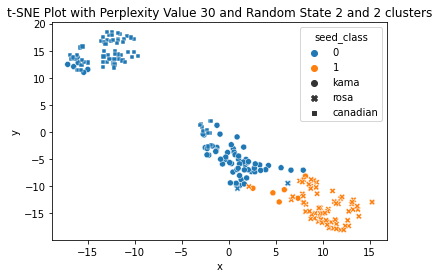

--------------------------------------------


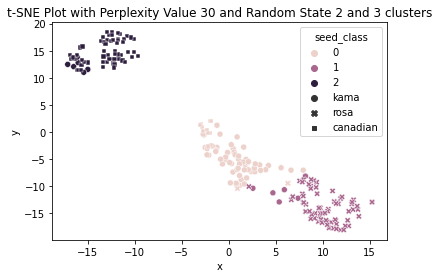

--------------------------------------------


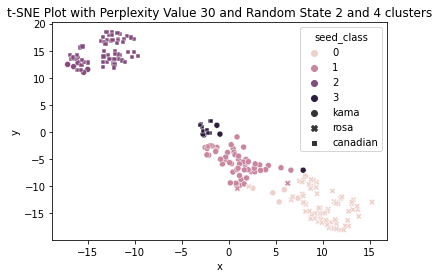

--------------------------------------------


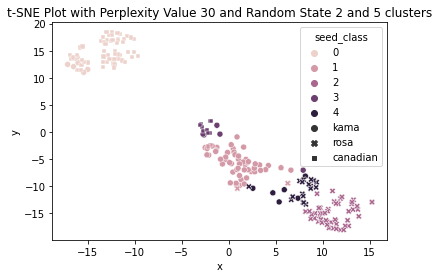

--------------------------------------------


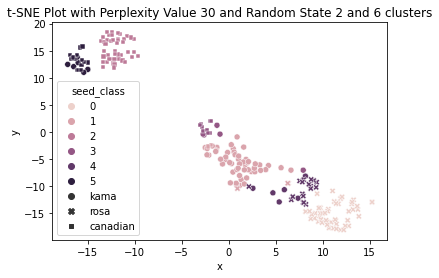

--------------------------------------------


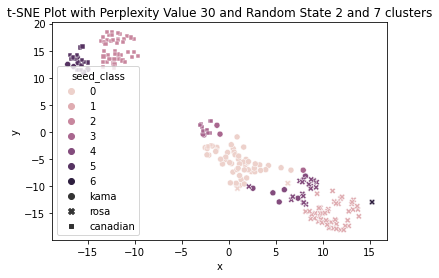

--------------------------------------------


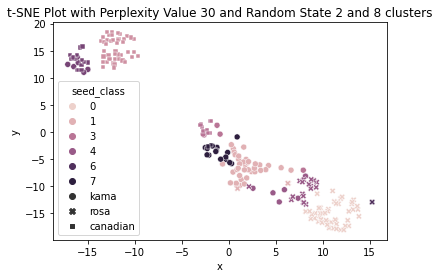

--------------------------------------------


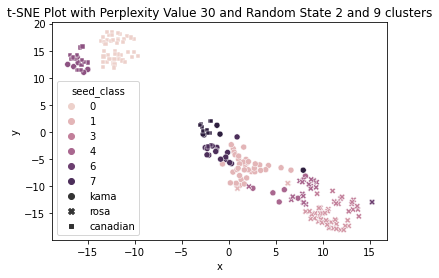

--------------------------------------------


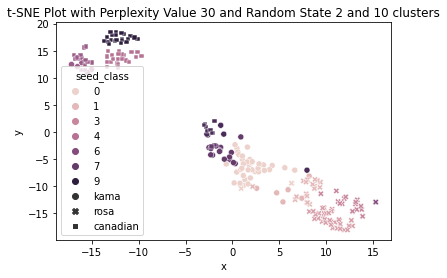

--------------------------------------------


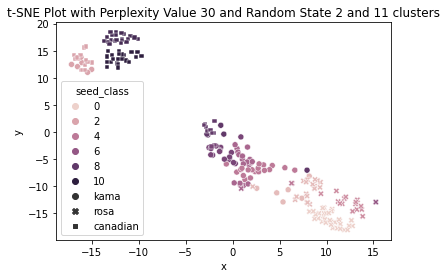

--------------------------------------------


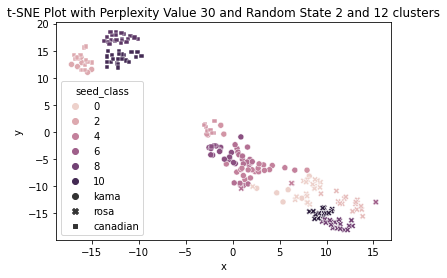

--------------------------------------------


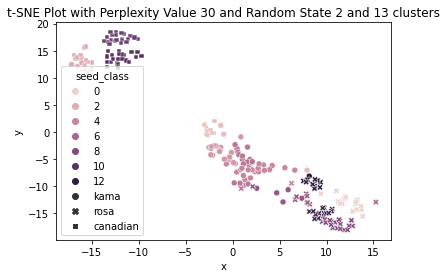

--------------------------------------------


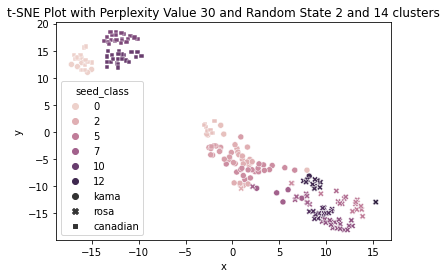

--------------------------------------------


In [100]:
data_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])
tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)

for k in range(2,15):
    #First, designate the HAC linkage function, and the number of clusters you want to extract from the resulting dendrogram
    hac = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    Y_pred = hac.fit_predict(X)
    perp = 30
    rs = 2

    df_combo = pd.concat([pd.DataFrame(Y_pred), df_tsne, df_stand.seed_class], axis=1)
    sns.scatterplot(x='x',y='y', hue=Y_pred, data=df_combo, style = df_stand.seed_class)
    plt.title('t-SNE Plot with Perplexity Value %s and Random State %s and %s clusters' %(perp, rs, k))
    plt.show()
    print('--------------------------------------------')

### 10. [1.5 pt] Select One Clustering

Suppose that the goal of this analysis is to find two "naturally occuring" sub-types for each of the three types of seeds. Thus you would want your clustering to have k=6 clusters.

(When we say "naturally occurring", this means that we have evidence to believe that there is some form of distinct separation between the two sub-types). With this goal in mind, select the best clustering from all of the clusterings that you examined in 6-9 above, that best meets this goal. **Explain your answer.**

**Generally speaking, for the purpose of our specific research goal with the seeds, we would not consider a singleton cluster a "subcluster" of seeds.**

Color-code the cluster labels for this clustering that you chose in your t-SNE plot below. Also, define the **shape** of the points by the seed class.



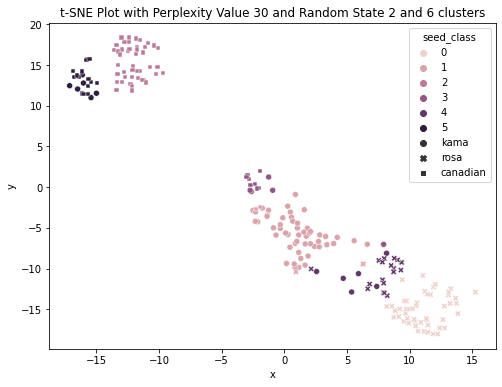

--------------------------------------------


In [106]:
data_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])
tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)

fig, ax = plt.subplots(figsize=(8, 6))

for k in [6]:
    #First, designate the HAC linkage function, and the number of clusters you want to extract from the resulting dendrogram
    hac = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    Y_pred = hac.fit_predict(X)
    perp = 30
    rs = 2

    df_combo = pd.concat([pd.DataFrame(Y_pred), df_tsne, df_stand.seed_class], axis=1)
    sns.scatterplot(x='x',y='y', hue=Y_pred, data=df_combo, style = df_stand.seed_class)
    plt.title('t-SNE Plot with Perplexity Value %s and Random State %s and %s clusters' %(perp, rs, k))
    plt.show()
    print('--------------------------------------------')

> I have selected ward linkage with 6 clusters that best depict the sub clusters.

> For canadian, we can see, the two sub clusters are well separated and have been correctly identified. Also, there are few objects in one cluster which belong to kama and not canadian.

> For kama, the two clusters contain some objects from other seed classes and the clusters are not well separated.

> For rosa, the two clusters contain some objects from other seed classes and the clusters are not well separated.

### 11. Learning More about Seed Class Subtypes

#### 11.1. [1.25 pt] t-SNE plots

Plot your t-SNE plot 7 times, each time color-coding the points by one of the scaled numerical attributes in your dataset. Also, define the **shape** of the points by the **cluster labels** in the clustering that you chose in 10. Define the size of the points by the seed class.

In [112]:
df_stand.columns

Index(['area', 'perimeter', 'compactness', 'kernel_length', 'width',
       'asymmetry_coefficient', 'kernel_groove_length', 'seed_class',
       'seed_class_and_id'],
      dtype='object')

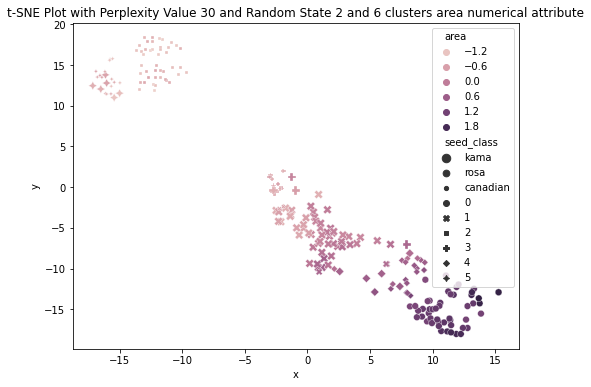

--------------------------------------------


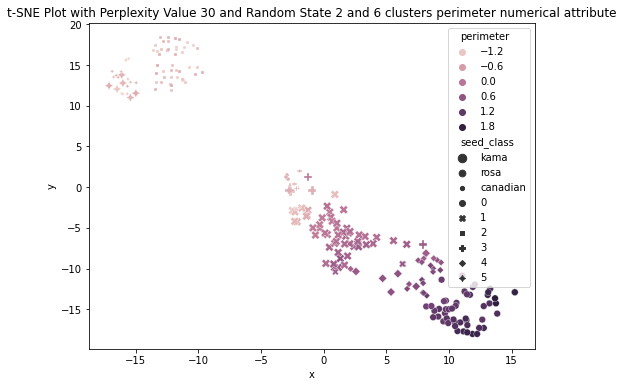

--------------------------------------------


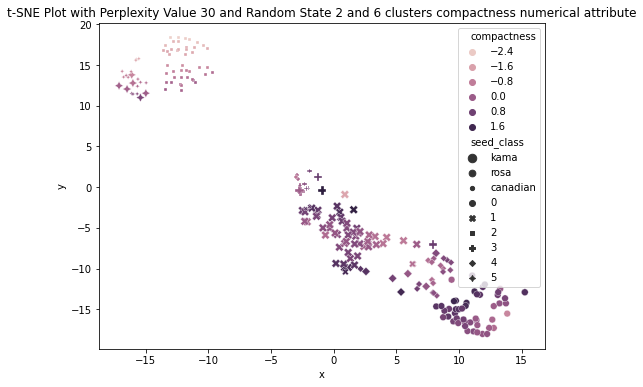

--------------------------------------------


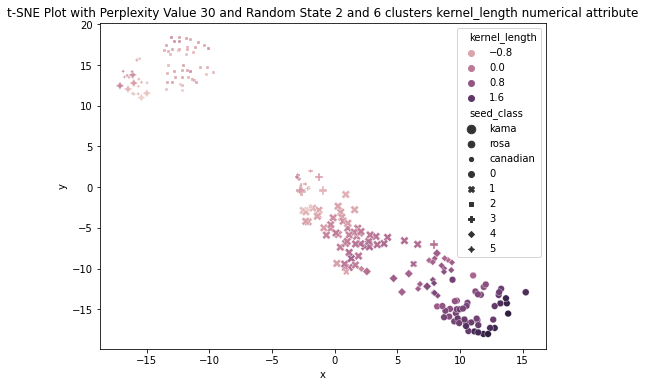

--------------------------------------------


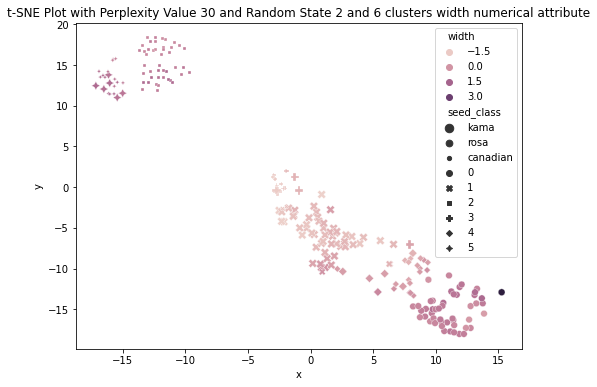

--------------------------------------------


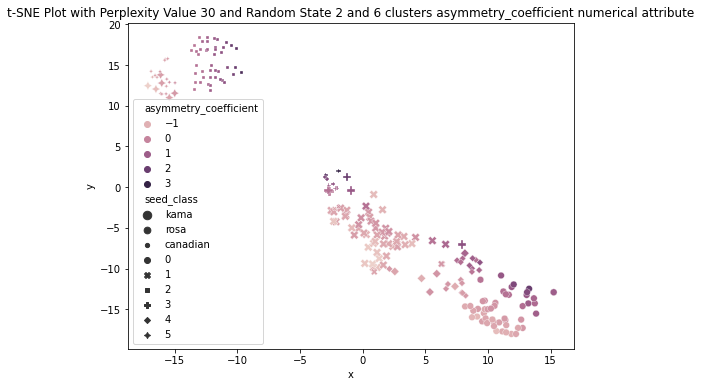

--------------------------------------------


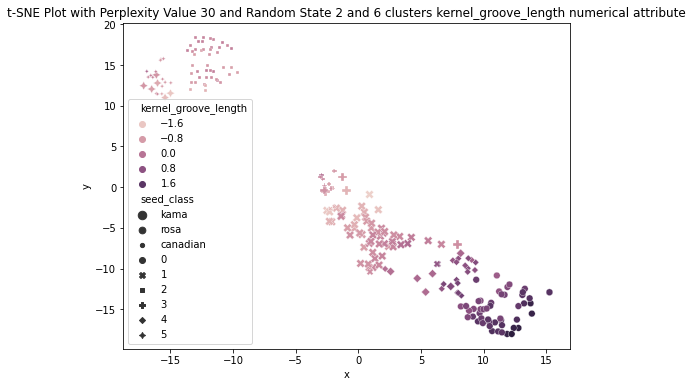

--------------------------------------------


In [115]:
data_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])
tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)

for i in range(7):
    #First, designate the HAC linkage function, and the number of clusters you want to extract from the resulting dendrogram
    hac = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    Y_pred = hac.fit_predict(X)
    perp = 30
    rs = 2
    
    df_combo = pd.concat([pd.DataFrame(Y_pred), df_tsne, df_stand.seed_class], axis=1)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.scatterplot(x='x',y='y', hue=df_stand.iloc[:, i], data=df_combo, style = Y_pred, size = df_stand.seed_class)
    plt.title('t-SNE Plot with Perplexity Value %s and Random State %s and %s clusters %s numerical attribute' %(perp, rs, k, df_stand.columns[i]))
    plt.show()
    print('--------------------------------------------')

#### 11.2 Seed Class Subtypes

Use the plots that you created above to answer the following questions.

* **11.2.1.** [0.5 pt] What is different about the two Canadian seed subtypes?
* **11.2.2.** [0.5 pt] What is different about the two kama seed subtypes?
* **11.2.3.** [0.5 pt] What is different about the two rosa seed subtypes?


> 11.2.1: Asymetric coefficient is different for the sub-clusters.

> 11.2.2: Kernel length, Asymetric coefficient, and kernel groove length is different for the two clusters.

> 11.2.3: Area, cluster perimeter, kernel length, and kernel groove length is different for the two clusters.

### 12. Cluster Similarity

Using the dendrogram that corresponds to the final clustering that you chose in 10, answer the following questions.

* **12.1**: Of the six clusters you selected, which cluster (or set of clusters) were considered to be most dissimilar to the other clusters? Explain.
* **12.2**: Of the six clusters you selected, which cluster (or set of clusters) were considered to be the second most dissimilar to other cluster(s)? Explain.

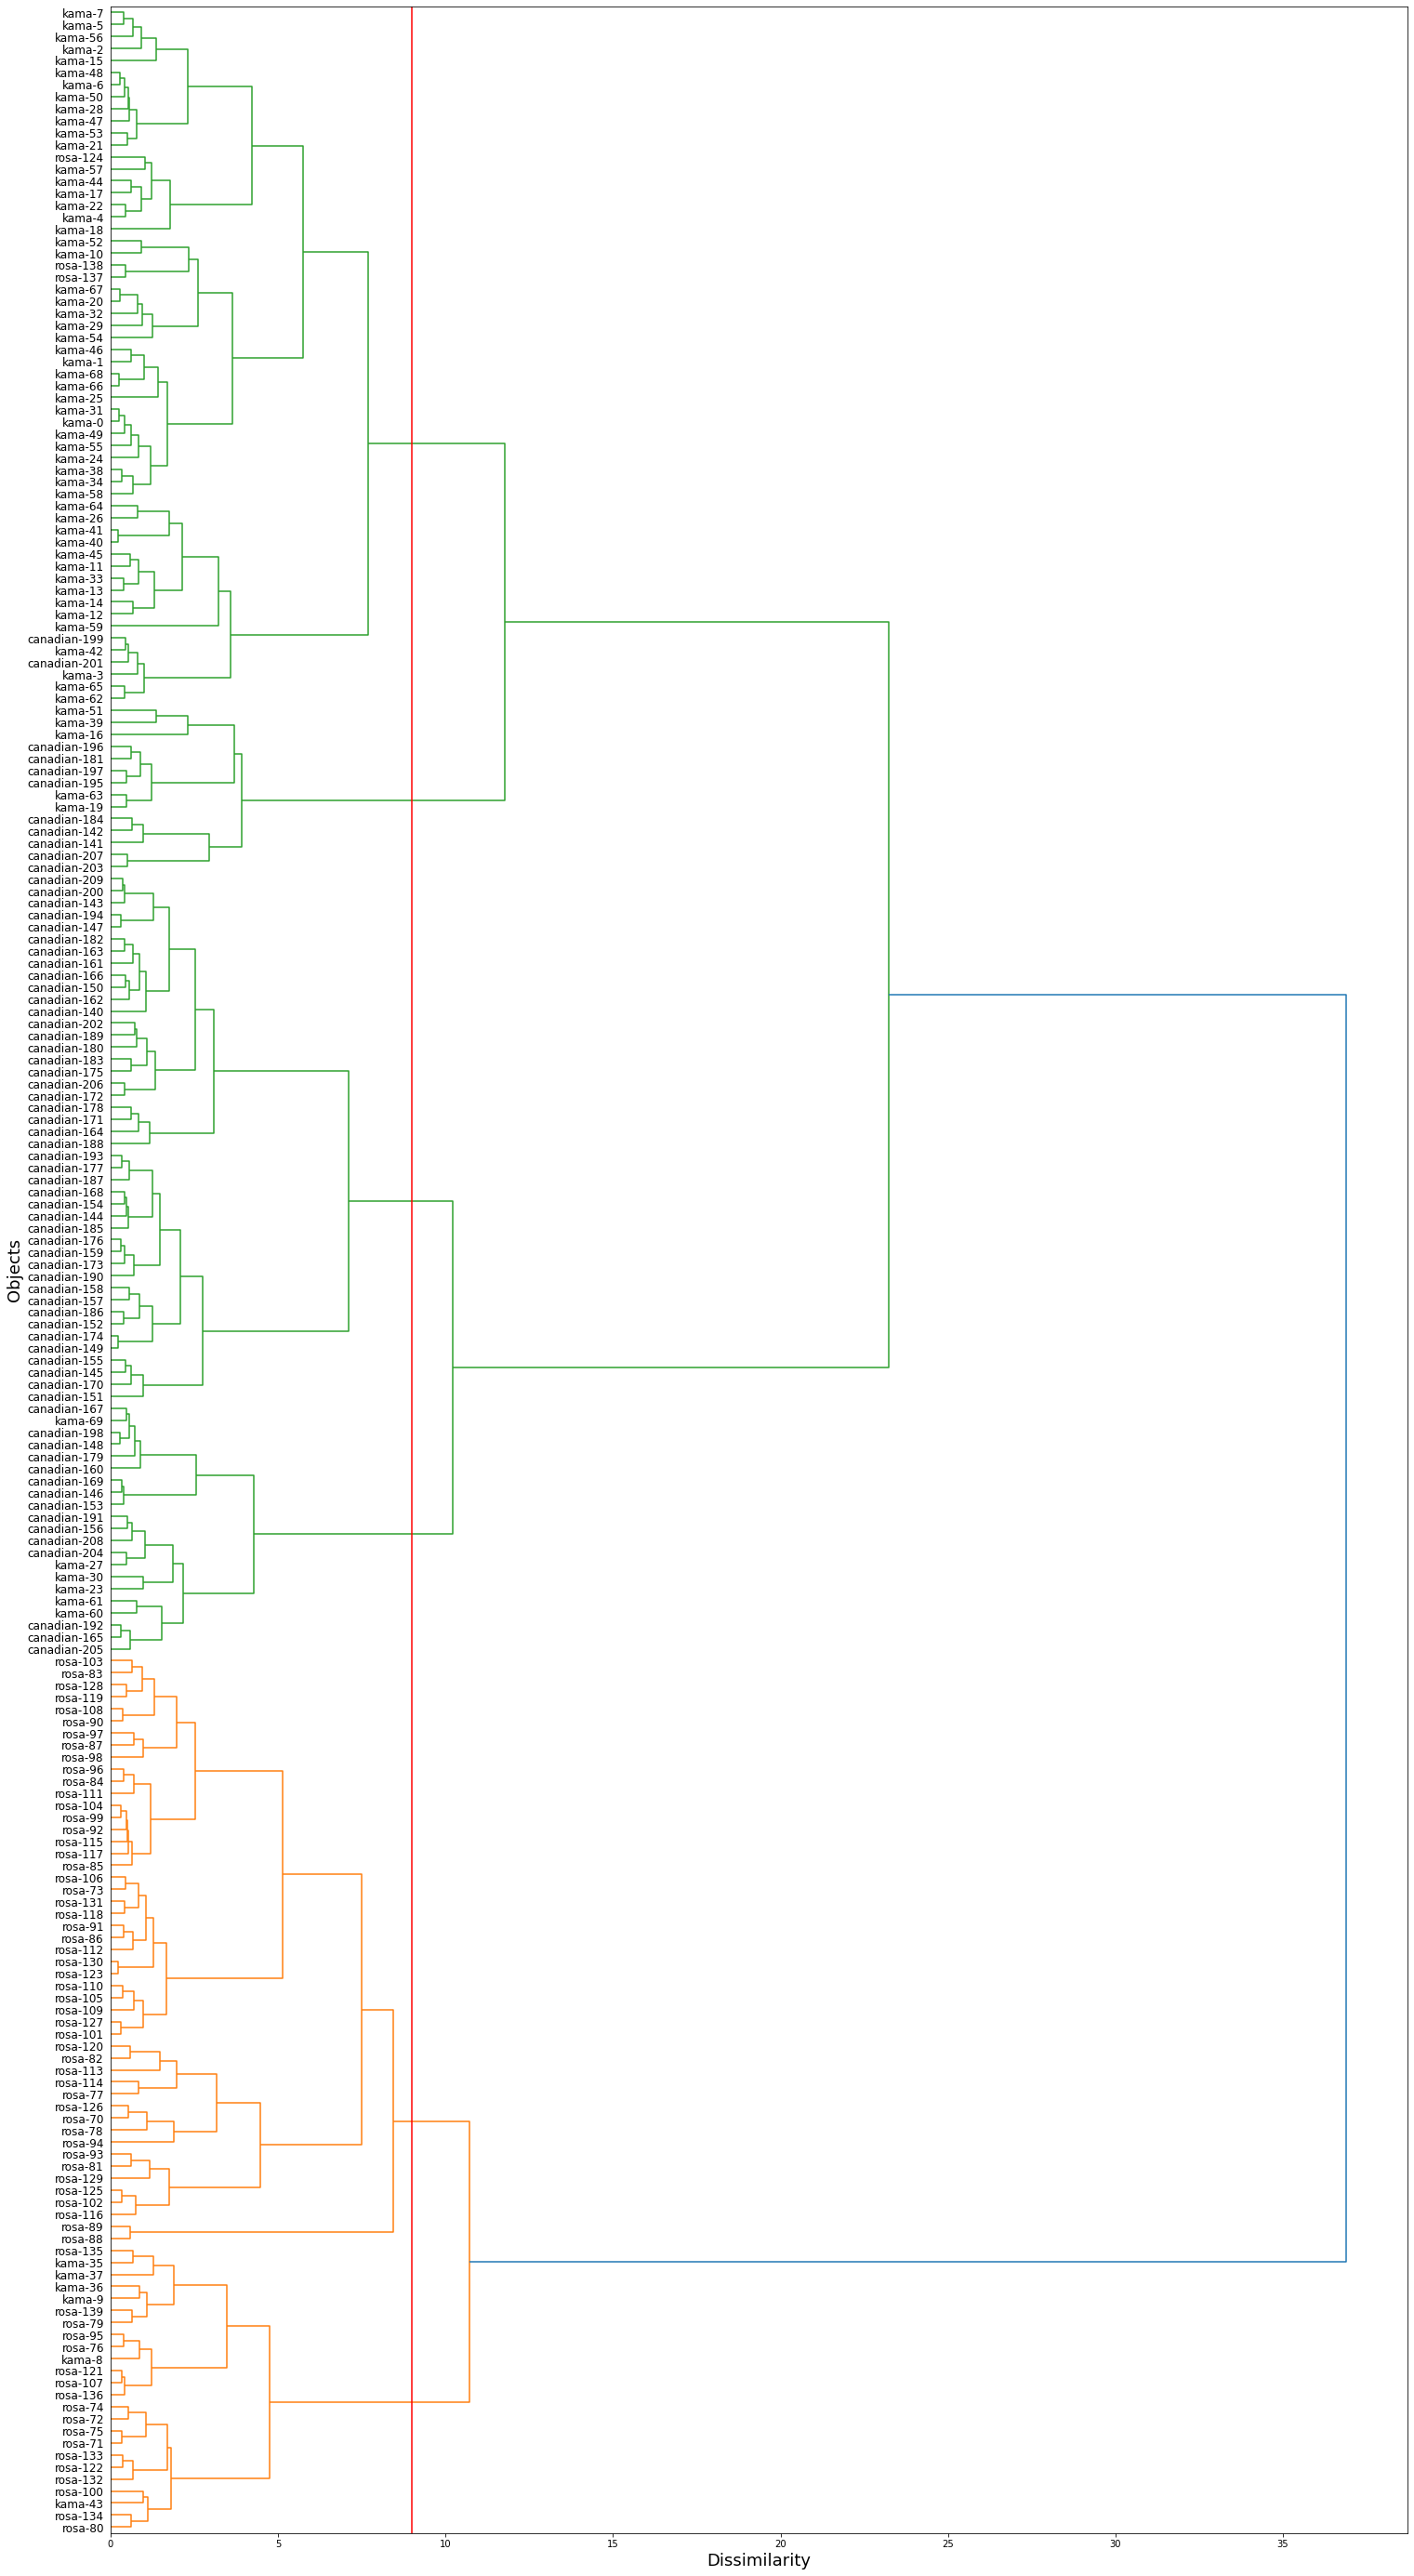

In [121]:
X = df_stand.iloc[:,:-2]
Z = linkage(X, method='ward')

fig, ax = plt.subplots(figsize=(25, 50))
d = dendrogram(Z, orientation='right', labels=df_stand.seed_class_and_id.array, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Objects', fontsize=18)
plt.yticks(fontsize=12)
plt.axvline(x=9, c='r')
plt.show()

> 12.1: Cluster containign larger portion of rosa class objects are most dissimilar since their proximity line cuts the dissimilarity axis at highest value.

> 12.2: Cluster containing large portion of kama objects are second most dissimilar.